<a href="https://colab.research.google.com/github/SidharthBaral/Rossmann-Retail_Sales_prediction/blob/main/Regression_Problem_Rossmann_Retail_Sales_Prediction_Final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title :**
#**Sales Prediction : Predicting sales of a major store chain Rossmann**

---



**Problem Description:**
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set.
##### **Note:** that some stores in the dataset were temporarily closed for refurbishment.

##**Data Description:**

---


Rossmann Stores Data.csv - historical data including Sales
store.csv - supplemental information about the stores
Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.
*  Id - an Id that represents a (Store, Date) duple within the test set
*  Store - a unique Id for each store
*  Sales - the turnover for any given day (this is what you are predicting)
*  Customers - the number of customers on a given day
*  Open - an indicator for whether the store was open: 0 = closed, 1 = open
*  StateHoliday - indicates a state holiday. Normally all stores, with few
 exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
*  SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
*  StoreType - differentiates between 4 different store models: a, b, c, d
*  Assortment - describes an assortment level: a = basic, b = extra, c = extended
*  CompetitionDistance - distance in meters to the nearest competitor store
*  CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
*  Promo - indicates whether a store is running a promo on that day
*  Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
*  Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
*  PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



#**GitHub Link:**


https://github.com/SidharthBaral/Rossmann-Retail_Sales_prediction

# **Problem Statement:**
Analysis of the historical Time-series sales data of Rossmann stores and build a machine learning model to forecast the sales of each Rossmann store upto 6 weeks.

# ***Let's Begin !***

## **Importing libraries and creating Custom functions**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

# For Feature Transformation
from sklearn.preprocessing import PowerTransformer,OneHotEncoder
# import category_encoders as ce

In [ ]:
def show_box_density_plot(data,lst):

   fig, axes = plt.subplots(nrows=len(lst), ncols=2, figsize=(12, 4*len(lst)))

    # Flatten axes for easy iteration
   axes = axes.flatten()

    # Plot box plots on the left and density plots on the right for each feature
   for i, feature in enumerate(data[lst]):
      # Box plot
      sns.boxplot(x=data[feature], ax=axes[i*2])
      axes[i*2].set_title(f'Box Plot - {feature}')

      # Density plot
      sns.histplot(data[feature], kde=True, ax=axes[i*2 + 1])
      axes[i*2 + 1].set_title(f'Density Plot - {feature}')

   plt.tight_layout()
   plt.show()

def show_box_plot(data,feature,s1,s2):
    plt.figure(figsize=(s1,s2))
    data[feature].boxplot()
    plt.xticks(rotation='horizontal')
    plt.show()

In [ ]:
def outlier_bounderies_percent(df,feature):


  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  # Define lower and upper bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Outlier percent in the entire column
  outlier_count = 0
  for i in df[feature]:
    if(i< lower_bound) or (i>upper_bound):
      outlier_count = outlier_count +1
  outlier_percent = round((outlier_count/df.shape[0])*100,2)
  return (lower_bound,upper_bound,f'{outlier_percent}%')


In [ ]:
def sales_customers_vs_categorical_variable(dataframe, feature):
  unique_values = sorted(dataframe[feature].unique().tolist())

  columns_num = 2
  rows_num = math.ceil(len(unique_values)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for unique_value in unique_values:

    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    temp_df = dataframe[dataframe[feature] == unique_value]
    sns.scatterplot(ax=axes[row, column], x='Customers', y='Sales', data=temp_df)
    lin_fit = np.polyfit(temp_df['Customers'], temp_df['Sales'], 1)
    lin_func = np.poly1d(lin_fit)(temp_df['Customers'])
    axes[row, column].plot(temp_df['Customers'], lin_func, "r--", lw=1)
    axes[row, column].set_title(f"Sales vs Customers for {feature} '{unique_value}'\nCorrelation = {round(temp_df['Customers'].corr(temp_df['Sales'])*100, 2)}%")
    axes[row, column].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

  if len(unique_values) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])


In [ ]:
import datetime
def get_start_month_end_month(week_number, year_name):

    first_day = datetime.datetime.strptime(f'{year_name}-01-01', '%Y-%m-%d')

    first_day_weekday = first_day.weekday()

    days_to_adjust = (7 - first_day_weekday) % 7

    start_date = first_day + datetime.timedelta(days=days_to_adjust + (week_number - 1) * 7)

    end_date = start_date + datetime.timedelta(days=6)

    start_month = start_date.month
    end_month = end_date.month
    return start_month, end_month


def get_month_number(year, week_number,promointerval):

    if (year==0)&(week_number==0):
      return 0
    else:
      start_date_month, end_date_month = get_start_month_end_month(week_number, year)

      if start_date_month == end_date_month:

        if start_date_month in promointerval:
          return start_date_month
        else:
          for month in promointerval:
            if start_date_month == 1:
              if 12 in promointerval:
                return 12
              elif 2 in promointerval:
                return 2

            if start_date_month == 12:
              if 1 in promointerval:
                return 1
              elif 11 in promointerval:
                return 11

            if (abs(start_date_month-month)==1)&(start_date_month !=1)&(start_date_month !=12):
              return month

      if start_date_month != end_date_month:

        if(start_date_month not in promointerval)&(end_date_month not in promointerval):
          for month in promointerval:
            if abs(start_date_month-month)==1:
              return month
            elif abs(end_date_month-month)==1:
              return month
        elif start_date_month in promointerval:
          return start_date_month
        elif end_date_month in promointerval:
          return end_date_month

##**Dataset loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/Rossmann Stores Data.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/store.csv")

In [ ]:
df1.shape,df2.shape

((1017209, 9), (1115, 10))

## **Understanding Data Variables**

In [ ]:
df1.columns, df2.columns

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday'],
       dtype='object'),
 Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
        'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
       dtype='object'))



*   We noticed that in the above datasets there is a common column 'Store'. Now we need to check if the unique values in both the dataset is same or not.

* If the number of unique values in 'Store' in both the datasets would be same then we can join both the datasets.





In [ ]:
df1.info(),df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assort

(None, None)

In [ ]:
print('Total unique values in Store column of df1: ',df1['Store'].nunique())
print('Total unique values in Store column of df2: ',df2['Store'].nunique())

Total unique values in Store column of df1:  1115
Total unique values in Store column of df2:  1115


### Variables Description

*  Store - a unique Id for each store
*  Sales - the turnover for any given day (this is what you are predicting)
*  Customers - the number of customers on a given day
*  Open - an indicator for whether the store was open: 0 = closed, 1 = open
*  StateHoliday - indicates a state holiday. Normally all stores, with few
 exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
*  SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
*  StoreType - differentiates between 4 different store models: a, b, c, d
*  Assortment - describes an assortment level: a = basic, b = extra, c = extended
*  CompetitionDistance - distance in meters to the nearest competitor store
*  CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
*  Promo - indicates whether a store is running a promo on that day
*  Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
*  Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
*  PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


## ***Data Wrangling***

**Droping Duplicate rows if any present in the dataset**



In [ ]:
df1.drop_duplicates(keep='last', inplace=True)
df2.drop_duplicates(keep='last', inplace=True)
print('df1: ',df1.shape)
print('df2: ',df2.shape)

df1:  (1017209, 9)
df2:  (1115, 10)




   We can clearly see that the dataset do not contain any duplicate entries.   Since the number of unique values in 'Store' in both the datasets is same so we can join both the datasets.





In [ ]:
data = pd.merge(df1, df2, how ='left', on ='Store')
data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [ ]:
data.shape

(1017209, 18)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
data.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  CompetitionDistance  \
count  1.017209e+06   1.017209e+06         1.014567e+06   
mean   3.815145e-01   1.786467e-01         5.430086e+03   
std    4.857586e-01   3.830564e-01         7.715324e+03   
min    0.000000e+00   0.000000e+00         2.000000e+01   
25%    0.000000e+00   0.000000e+00         7.100000e+02   
50%    0.000000e+00   0.000000e+00         2.330000e+03   
75%    1.000000e+00   0.000000e+00         6.890000e+03   
max    1.000000e+00   1.000000e+00         7.586000e+04   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear        Promo2  \
count              693861.000000             693861.000000  1.017209e+06   
mean                    7.222866               2008.690228  5.005638e-01   
std                     3.211832                  5.992644  4.999999e-01   
min                     1.000000               1900.000000  0.000000e+00   
25%                     4.000000               2006.000000  0.000000e+00   
50%                     8.000000               2010.000000  1.000000e+00   
75%                    10.000000               2013.000000  1.000000e+00   
max                    12.000000               2015.000000  1.000000e+00   

       Promo2SinceWeek  Promo2SinceYear  
count    509178.000000    509178.000000  
mean         23.269093      2011.752774  
std          14.095973         1.662870  
min           1.000000      2009.000000  
25%          13.000000      2011.000000  
50%          22.000000      2012.000000  
75%          37.000000      2013.000000  
max          50.000000      2015.000000

##**Null Imputation**

In [ ]:
print('Null values in(%) each column of the dataset:')
(data.isnull().sum()/data.shape[0])*100

Null values in(%) each column of the dataset:


Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

**We can see that the columns like 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval' have approximately 50% Null values.Since these columns are important factors that govern sales so these features can't be dropped.**

In [ ]:
data['CompetitionDistance'].describe()

count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

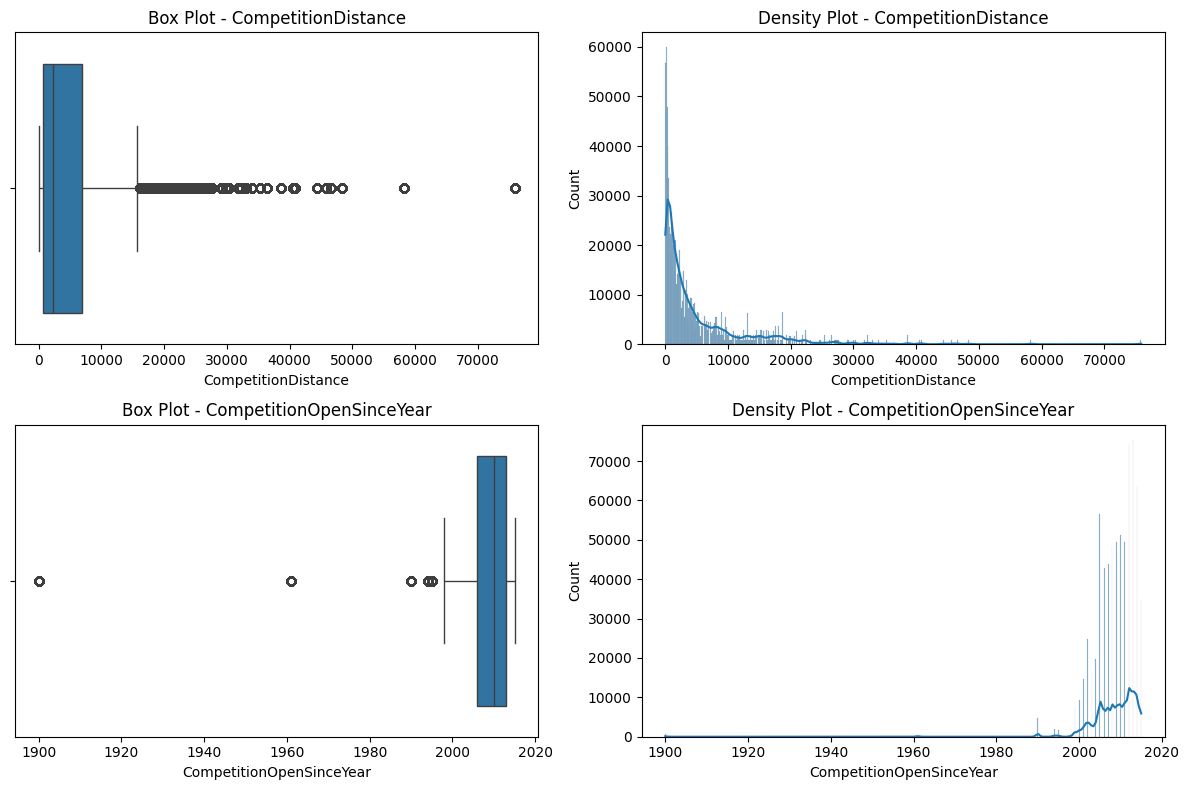

In [ ]:
lst = ['CompetitionDistance','CompetitionOpenSinceYear']
show_box_density_plot(data,lst)



*   In 'CompetitionDistance' column the null value percentage is around 0.26%. We will be replacing the null value with the **maximum** value of the column.

*   Since 'CompetitionOpenSinceYear' is highly skewed so the Null values in the column should be replaced by the **mode** value of the column.
*  Since 'CompetitionOpenSinceMonth' feature is a categorical feature which contains months hence the null values must be replaced by **mode** value of the column
*  Since 'Promo2SinceWeek' and 'Promo2Sinceyear'and 'PromoInterval' are the categorical columns which contain around 50% of null values so replacing all the null values by mode value may not be a wise decision. so we will be replacing these null values by **some other value say '0'**.



In [ ]:
data['CompetitionDistance'].fillna(data['CompetitionDistance'].max(),inplace = True)
data['CompetitionOpenSinceYear'].fillna(data['CompetitionOpenSinceYear'].mode()[0],inplace = True)
data['CompetitionOpenSinceMonth'].fillna(data['CompetitionOpenSinceMonth'].mode()[0],inplace = True)
data['Promo2SinceWeek'].fillna(0,inplace = True)
data['Promo2SinceYear'].fillna(0,inplace = True)
data['PromoInterval'].fillna(0,inplace = True)

In [ ]:
data[lst].isnull().sum()

CompetitionDistance         0
CompetitionOpenSinceYear    0
dtype: int64

### Checking Unique Values for each variable.

In [ ]:
for col in list(data.columns):
  print('Unique values in {}: {}'.format(col,data[col].unique()))
  print('--'*30)

Unique values in Store: [   1    2    3 ... 1113 1114 1115]
------------------------------------------------------------
Unique values in DayOfWeek: [5 4 3 2 1 7 6]
------------------------------------------------------------
Unique values in Date: ['2015-07-31' '2015-07-30' '2015-07-29' '2015-07-28' '2015-07-27'
 '2015-07-26' '2015-07-25' '2015-07-24' '2015-07-23' '2015-07-22'
 '2015-07-21' '2015-07-20' '2015-07-19' '2015-07-18' '2015-07-17'
 '2015-07-16' '2015-07-15' '2015-07-14' '2015-07-13' '2015-07-12'
 '2015-07-11' '2015-07-10' '2015-07-09' '2015-07-08' '2015-07-07'
 '2015-07-06' '2015-07-05' '2015-07-04' '2015-07-03' '2015-07-02'
 '2015-07-01' '2015-06-30' '2015-06-29' '2015-06-28' '2015-06-27'
 '2015-06-26' '2015-06-25' '2015-06-24' '2015-06-23' '2015-06-22'
 '2015-06-21' '2015-06-20' '2015-06-19' '2015-06-18' '2015-06-17'
 '2015-06-16' '2015-06-15' '2015-06-14' '2015-06-13' '2015-06-12'
 '2015-06-11' '2015-06-10' '2015-06-09' '2015-06-08' '2015-06-07'
 '2015-06-06' '2015-06-05

In [ ]:
data[data['Sales']==0].shape

(172871, 18)

### **Modifying Data types of required column**

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data['CompetitionOpenSinceMonth'] = data['CompetitionOpenSinceMonth'].astype(int)
data['CompetitionOpenSinceYear'] = data['CompetitionOpenSinceYear'].astype(int)

data['StateHoliday'].replace(['a','b','c'], 1, inplace=True)
data['StateHoliday'] = data['StateHoliday'].astype(int)

data['Promo2SinceWeek'] = data['Promo2SinceWeek'].astype(int)
data['Promo2SinceYear'] = data['Promo2SinceYear'].astype(int)

print('Date: ',data['Date'].dtype)
print('CompetitionOpenSinceMonth: ',data['CompetitionOpenSinceMonth'].dtype)
print('CompetitionOpenSinceYear: ',data['CompetitionOpenSinceYear'].dtype)
print('StateHoliday: ',data['StateHoliday'].dtype)
print('Promo2SinceWeek: ',data['Promo2SinceWeek'].dtype)
print('Promo2SinceYear: ',data['Promo2SinceYear'].dtype)


Date:  datetime64[ns]
CompetitionOpenSinceMonth:  int64
CompetitionOpenSinceYear:  int64
StateHoliday:  int64
Promo2SinceWeek:  int64
Promo2SinceYear:  int64


In [ ]:
data.shape

(1017209, 18)

In [ ]:
data.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Rechecking the datatype of the columns of the dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  int64         
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [ ]:
numeric_data = data.select_dtypes(include=['number'])
skewness = numeric_data.skew()
skewness

Store                       -0.000955
DayOfWeek                    0.001593
Sales                        0.641460
Customers                    1.598650
Open                        -1.758045
Promo                        0.487838
StateHoliday                 5.458198
SchoolHoliday                1.677842
CompetitionDistance          3.599472
CompetitionOpenSinceMonth   -0.714064
CompetitionOpenSinceYear    -7.884662
Promo2                      -0.002255
Promo2SinceWeek              1.003390
Promo2SinceYear             -0.002251
dtype: float64

We can see that some of the features in the dataset are skewed. Hence we will be removing outliers using IQR method.

##**Feature Extraction**

In [ ]:
data['WeekOfYear'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

data['CompetitionDurationMonths'] = (data['Year'] - data['CompetitionOpenSinceYear']) * 12 + (data['Month'] - data['CompetitionOpenSinceMonth'])

data['PromoMonth'] = data['Month'].where(data['Promo'] == 1, 0)
data['PromoWeek'] = data['WeekOfYear'].where(data['Promo'] == 1, 0)
data['Promotions'] = data['Promo']+data['Promo2']

In [ ]:
def extract_promo_months(promo_interval):
  months = []
  if promo_interval ==0:
    return 0
  else:
    for month_str in promo_interval.split(','):
        month_str = month_str.strip()
        # Convert month abbreviation to its numerical representation
        month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                     'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
        month_num = month_map.get(month_str)
        if month_num:
            months.append(month_num)
    return months

data['PromoInterval'] = data.apply(lambda  x: extract_promo_months(x['PromoInterval']), axis=1)


In [ ]:
data['Promo2Month'] = data.apply(lambda x: get_month_number(x['Promo2SinceYear'], x['Promo2SinceWeek'],x['PromoInterval']), axis=1)

In [ ]:
data['Difference_in_Promotions'] = np.where((data.Promotions==2),abs(data.PromoMonth-data.Promo2Month),0)

In [ ]:
data['Difference_in_Promotions'].value_counts()

Difference_in_Promotions
0     839414
1      30890
2      28258
3      26803
4      19914
5      17905
6      16180
7      14116
8      11329
9       8145
10      3135
11      1120
Name: count, dtype: int64

**Checking CompetitionDurationMonths distribution**

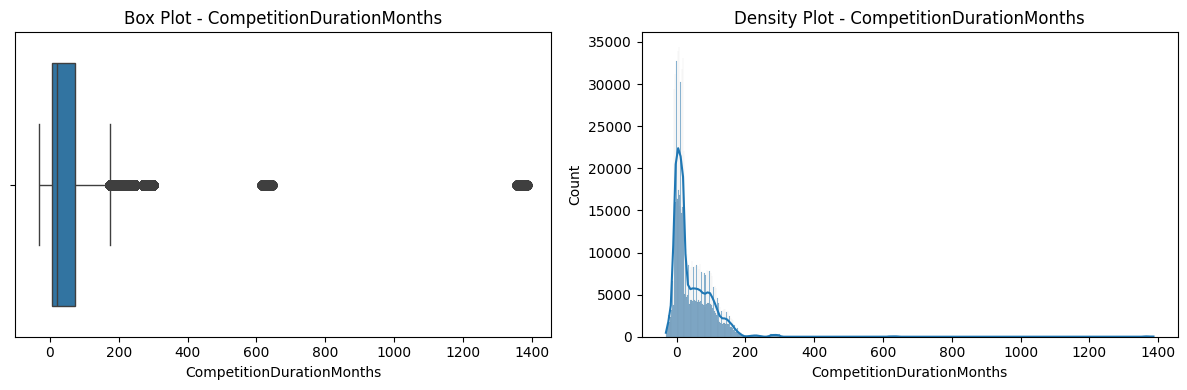

In [ ]:
show_box_density_plot(data,['CompetitionDurationMonths'])

In [ ]:
data[data.CompetitionDurationMonths<0][['Year', 'Month','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','CompetitionDurationMonths']].head()

Year  Month  CompetitionOpenSinceYear  CompetitionOpenSinceMonth  \
687   2015      7                      2015                          8   
1019  2015      7                      2015                          8   
1071  2015      7                      2015                          8   
1802  2015      7                      2015                          8   
2134  2015      7                      2015                          8   

      CompetitionDurationMonths  
687                          -1  
1019                         -1  
1071                         -1  
1802                         -1  
2134                         -1

We can clearly see that the Competetive stores were established earlier than the Rossmann stores hence the values in CompetitionDurationMonths were negative


**Let's change the negative values in the CompetitionDurationMonths to 0**

In [ ]:
data['CompetitionDurationMonths'] = data['CompetitionDurationMonths'].apply(lambda x: 0 if x < 0 else x)

**Looking for Refurbishments in the dataset**

In [ ]:
data[(data.SchoolHoliday==0) & (data.StateHoliday==0)].Open.value_counts(normalize=True)*100

Open
1    82.973331
0    17.026669
Name: proportion, dtype: float64

In [ ]:
data['Holiday'] = np.where(((data.SchoolHoliday==1)&(data.StateHoliday==1)),1,0)
data.Holiday.value_counts(normalize=True)*100

Holiday
0    98.475141
1     1.524859
Name: proportion, dtype: float64

In [ ]:
data.groupby('Holiday')['Open'].value_counts(normalize=True)*100

Holiday  Open
0        1       84.264719
         0       15.735281
1        0       97.975630
         1        2.024370
Name: proportion, dtype: float64

In [ ]:
data.groupby('Holiday')['Open'].value_counts()

Holiday  Open
0        1       844078
         0       157620
1        0        15197
         1          314
Name: count, dtype: int64

*   Since the provided data contains a chunk of data which represents the stores under refurbishment hence we need to drop the data. Because it is obvious that the shops under refurbishment is not going to contribute any sales.




###Finding Refurbishment data

In [ ]:
no_sales_data = data[(data['Holiday'] == 0) & (data['Open'] == 0)]
refurbishment_data_indices = no_sales_data.index
print("Number of Retail shops under Refurbishment in original data: ", end='')
print(len(refurbishment_data_indices))

Number of Retail shops under Refurbishment in original data: 157620


In [ ]:
refurbishment_data = data.iloc[refurbishment_data_indices]
refurbishment_data.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
291     292          5 2015-07-31      0          0     0      1   
875     876          5 2015-07-31      0          0     0      1   
1406    292          4 2015-07-30      0          0     0      1   
1990    876          4 2015-07-30      0          0     0      1   
2521    292          3 2015-07-29      0          0     0      1   

      StateHoliday  SchoolHoliday StoreType  ... WeekOfYear  Month  Year  \
291              0              1         a  ...         31      7  2015   
875              0              1         a  ...         31      7  2015   
1406             0              1         a  ...         31      7  2015   
1990             0              1         a  ...         31      7  2015   
2521             0              1         a  ...         31      7  2015   

      CompetitionDurationMonths  PromoMonth  PromoWeek  Promotions  \
291                          73           7         31           1   
875                         123           7         31           2   
1406                         73           7         31           1   
1990                        123           7         31           2   
2521                         73           7         31           1   

     Promo2Month  Difference_in_Promotions  Holiday  
291            0                         0        0  
875            5                         2        0  
1406           0                         0        0  
1990           5                         2        0  
2521           0                         0        0  

[5 rows x 28 columns]

In [ ]:
print('Shape of given data: ',data.shape)

Shape of given data:  (1017209, 28)


In [ ]:
data.Date.min(),data.Date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [ ]:
unseen_data = data.loc[(data.Date<='2015-07-31 00:00:00')&(data.Date>= '2015-06-15 00:00:00')]

Since we are given a task to predict the daily sales for up to six weeks in advance, we will be droping the last six weeks data from the current dataset and we will be storing the same data in another dataframe known as **'unseen_data'**.

In [ ]:
unseen_data.Date.min(),unseen_data.Date.max()

(Timestamp('2015-06-15 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [ ]:
unseen_data.shape

(52405, 28)

In [ ]:
unseen_data.head(1)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   

   SchoolHoliday StoreType  ... WeekOfYear  Month  Year  \
0              1         c  ...         31      7  2015   

   CompetitionDurationMonths  PromoMonth  PromoWeek  Promotions Promo2Month  \
0                         82           7         31           1           0   

   Difference_in_Promotions  Holiday  
0                         0        0  

[1 rows x 28 columns]

In [ ]:
unseen_data.tail(1)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
52404   1115          1 2015-06-15  10853        623     1      1   

       StateHoliday  SchoolHoliday StoreType  ... WeekOfYear  Month  Year  \
52404             0              0         d  ...         25      6  2015   

       CompetitionDurationMonths  PromoMonth  PromoWeek  Promotions  \
52404                         21           6         25           2   

      Promo2Month  Difference_in_Promotions  Holiday  
52404           6                         0        0  

[1 rows x 28 columns]

In [ ]:
data = data.loc[data.Date<'2015-06-15 00:00:00']
data.Date.max(),data.Date.min()

(Timestamp('2015-06-14 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [ ]:
data.head(1)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
52405      1          7 2015-06-14      0          0     0      0   

       StateHoliday  SchoolHoliday StoreType  ... WeekOfYear  Month  Year  \
52405             0              0         c  ...         24      6  2015   

       CompetitionDurationMonths  PromoMonth  PromoWeek  Promotions  \
52405                         81           0          0           0   

      Promo2Month  Difference_in_Promotions  Holiday  
52405           0                         0        0  

[1 rows x 28 columns]

## **Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables**

In [ ]:
data.shape

(964804, 28)

###**Univariate Analysis**

In [ ]:
try:
  def apply_percent(axes):
    '''Takes axes as input and labels the percent count of each bar in a countplot'''
    for p in plot.patches:
        total = sum(p.get_height() for p in plot.patches)/100
        percent = round((p.get_height()/total),2)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        plot.annotate(f'{percent}%', (x, y), ha='center', va='bottom')
except:
    print ("An error occurred")

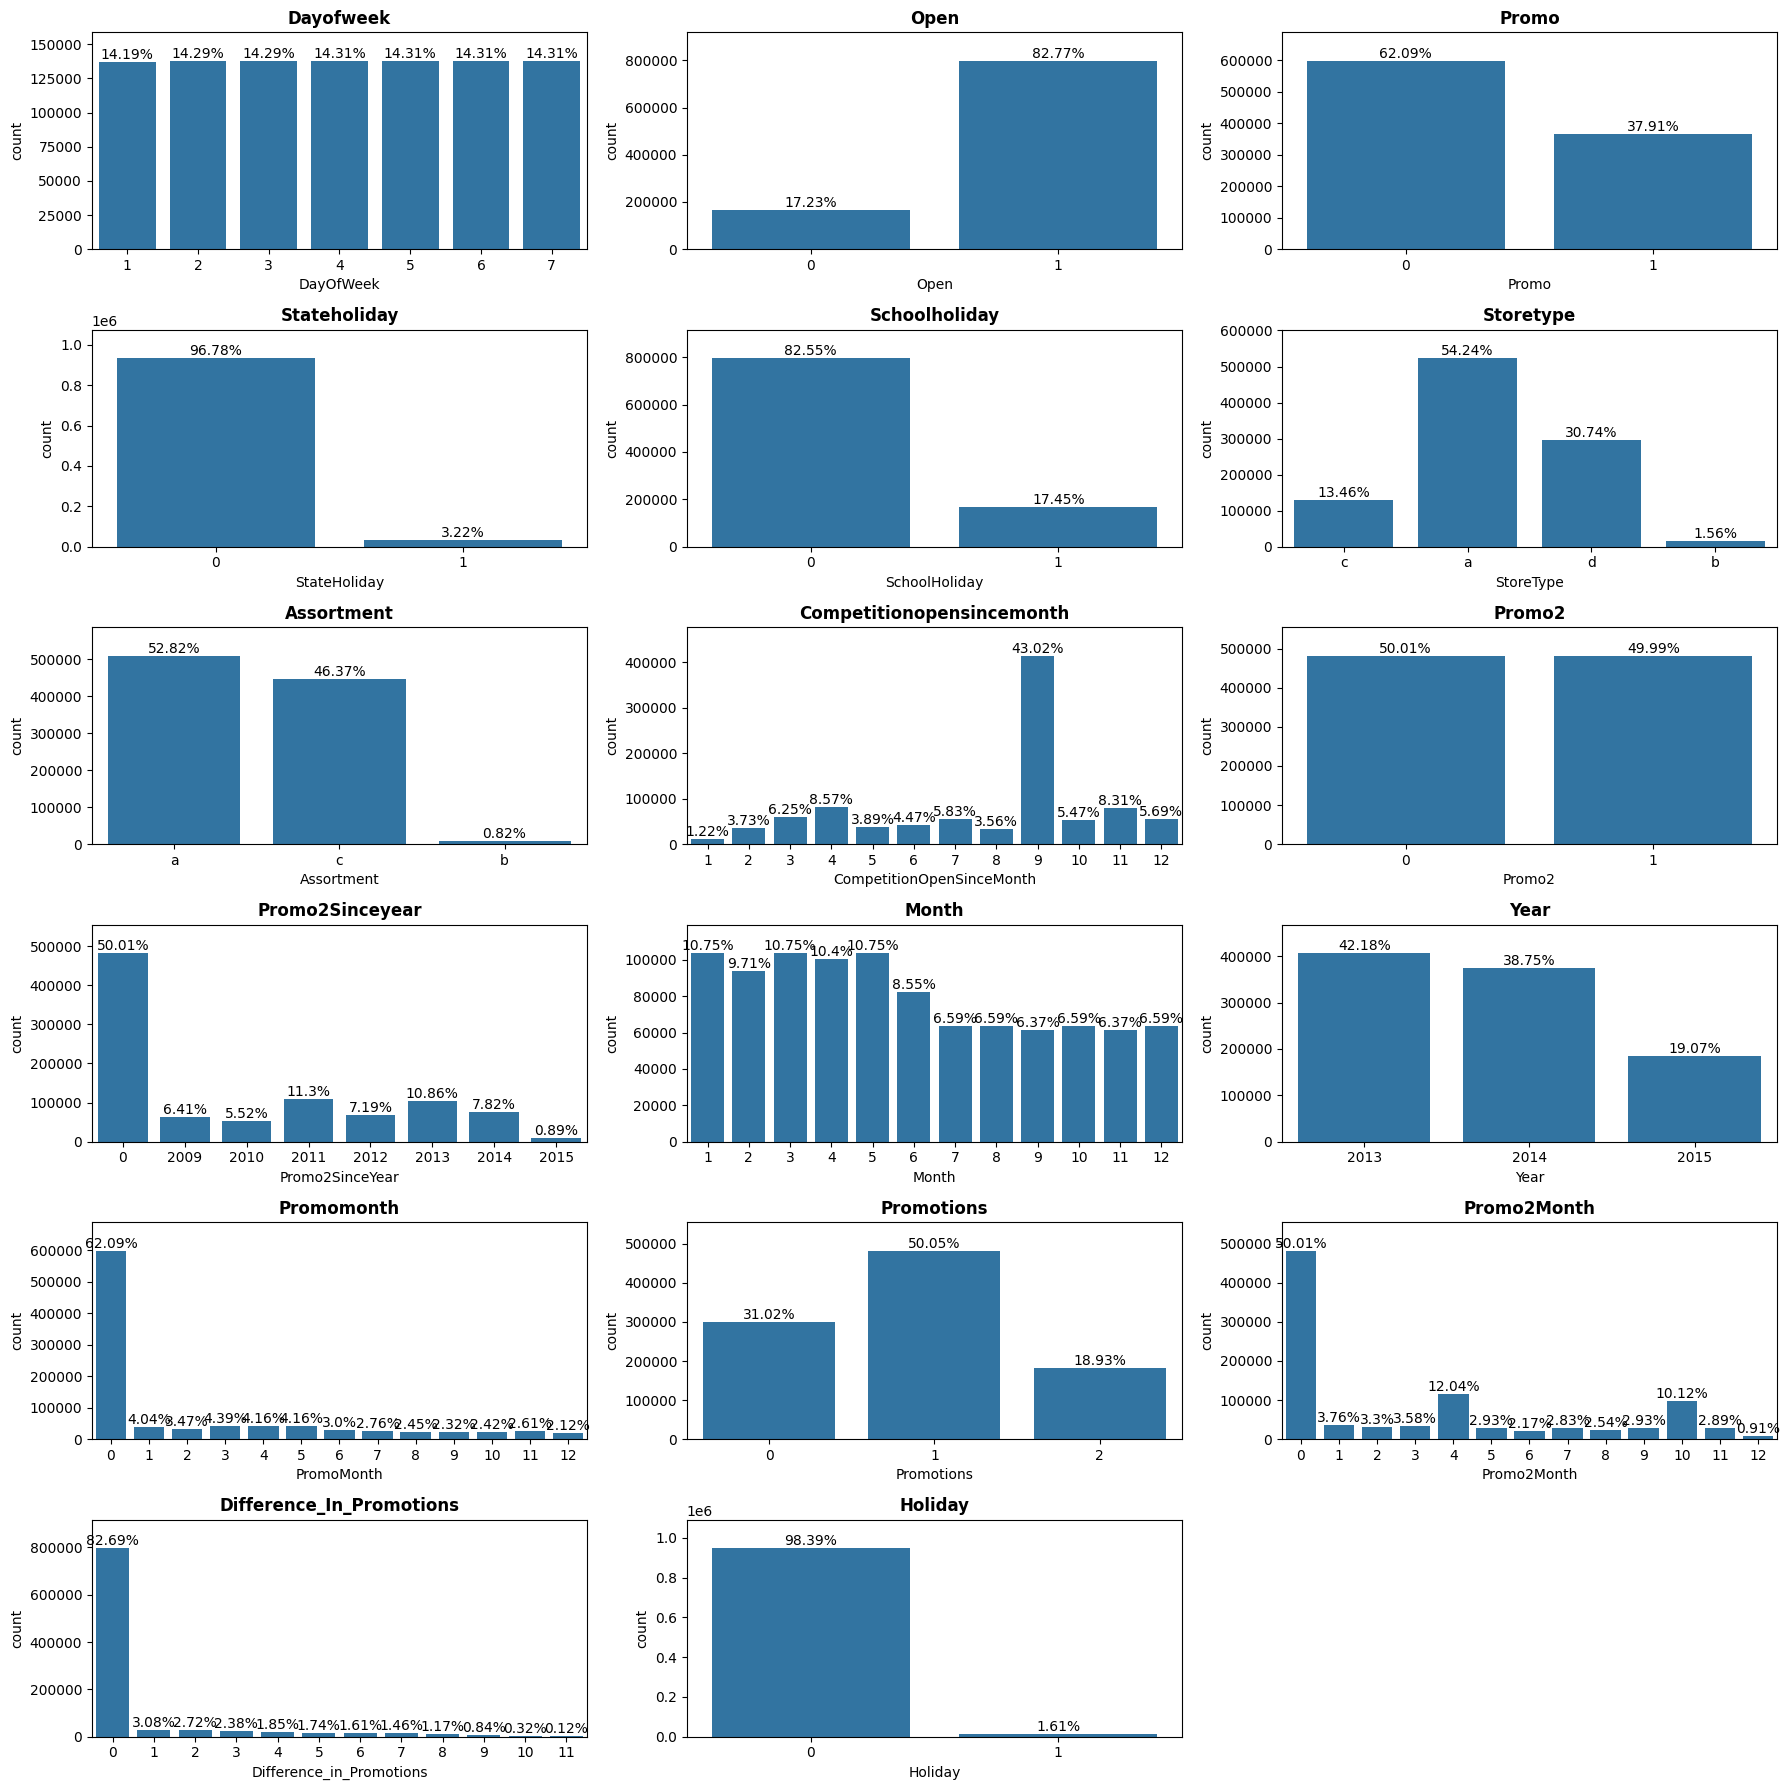

In [ ]:
req_features = [col for col in data.columns if (len(data[col].value_counts())<=15)& (col != 'PromoInterval')]
r = int(len(req_features)/3 +1)

'''Plotting graphs for each feature in the req_feature list. '''

plt.figure(figsize=(18,r*3))
for n,var in enumerate(req_features):
    plot = plt.subplot(r,3,n+1)
    sns.countplot(x=data[var]).margins(y=0.15)
    plt.title(f'{var.title()}',weight='bold')
    plt.tight_layout()

    apply_percent(plot)


* The dataset contains retail sales data of past 3 years.The year 2013 contributes 42.18% data, year 2024 contributes 38.75% data and year 2015 contributes 19.07% data w.r.t entire data.
* Around 62% of the retail stores do not participate in promotional activities and 38% of retail shops participate in protional activities.
* 50% of the retail shops participate in promo2.
* 18.93% of stores participate in both kind of promotional activities
* Most of the Stores belong to category 'a' followed by 'd' and 'c'
* Out of all Assortments, 'a' followed by 'c' are most popular.
* Mostly the competitor retail shops are old. The competitor shops are mostly 9 to 12 months old.
* In the first two quaters the retail stores are making business as compared to last two quaturs of a year.


###**Bivariate Analysis**

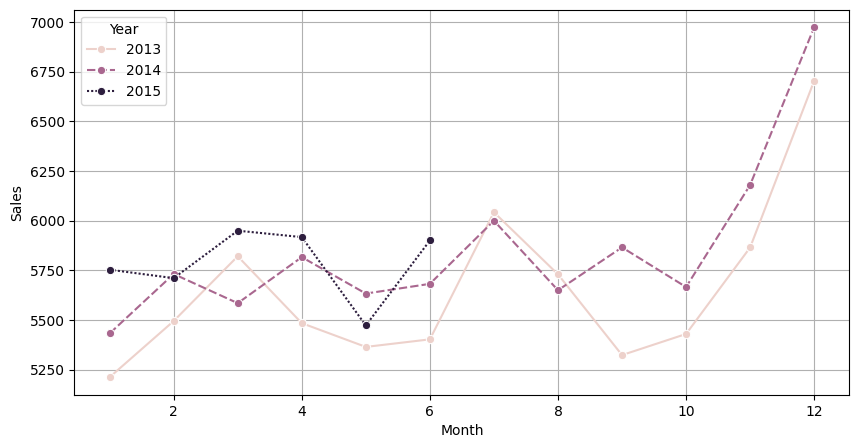

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month", y="Sales",
             hue="Year", style="Year", marker ='o',ci =None,
             data=data)
plt.grid()
plt.show()

**Reason for picking the above chart:**

The reason for picking lineplot is simple. The **Sales** column is a numeric feature. There is a possibility that it would change its value with time.

**Observations**
* We can clearly see that maximum sales are made by the stores in the month of December.
* The sales value of the stores get their maximum values in the month of 'March', 'September','December'.
* Overall sales are increasing every year.


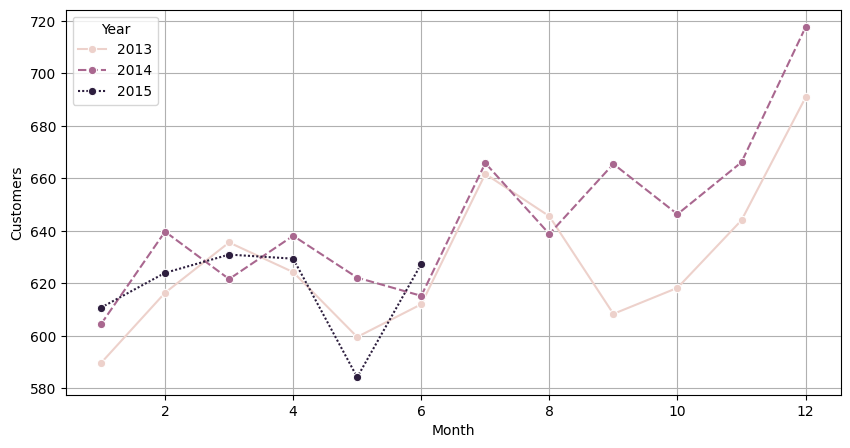

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(x="Month", y="Customers",
             hue="Year", style="Year", marker ='o',ci =None,
             data=data)
plt.grid()
plt.show()

**Reason for picking the above chart:**

The **Customers** column is a numeric feature. There is a possibility that it would change its value with time. Hence lineplot is chossen.

**Observations**
* From both the above graphs it can be realised that sales and customers are strongly co-related to eachother.
* We can see that every year the number of customers increase considerabely.
* In the month of 'March', 'September' and 'December' the stores find more number of customers every year.

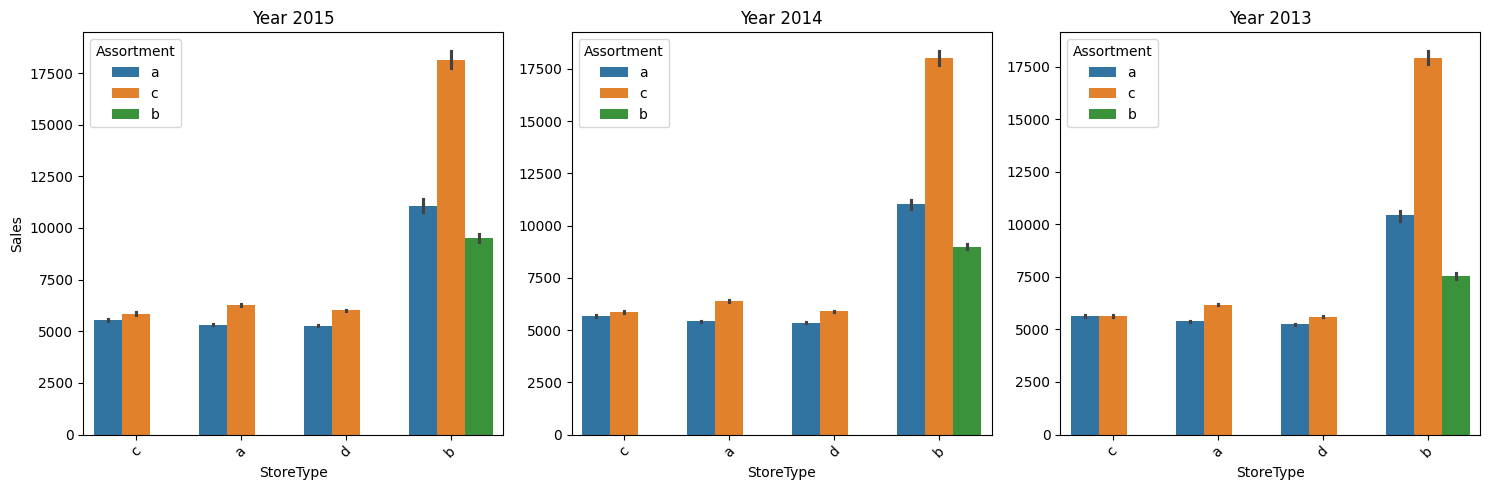

In [ ]:
unique_years = data['Year'].unique()

fig, axes = plt.subplots(1, len(unique_years), figsize=(15, 5))

for i, year in enumerate(unique_years):

    data_year = data[data['Year'] == year]

    sns.barplot(x='StoreType', y='Sales', hue='Assortment', data=data_year, ax=axes[i])

    axes[i].set_title(f'Year {year}')
    if i == 0:
        axes[i].set_ylabel('Sales')
    else:
        axes[i].set_ylabel('')

    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Reason for picking the above chart:**

We are considering **'StoreType'** as a categorical feature and **'Sales'** as numeric and continuous variable hence we considered bar plot.

**Observations:**

* 'a' and 'c' the common assortment type found in all store types.
* Assortment type 'b' is found only in store type 'b'.
* Maximum sales are done by store type 'b' in all assortment catrgories.

In [ ]:
data.WeekOfYear

52405      24
52406      24
52407      24
52408      24
52409      24
           ..
1017204     1
1017205     1
1017206     1
1017207     1
1017208     1
Name: WeekOfYear, Length: 964804, dtype: UInt32

<Axes: xlabel='CompetitionDistance', ylabel='Customers'>

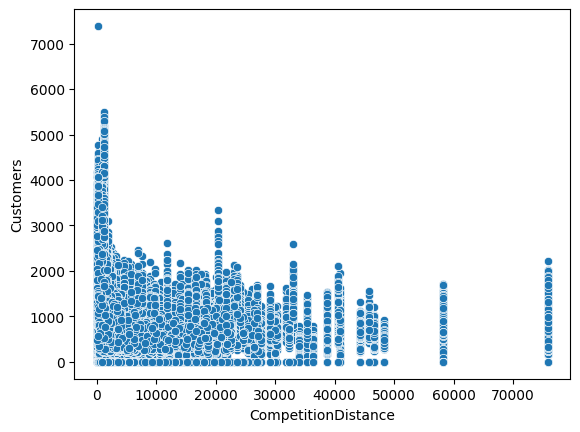

In [ ]:
sns.scatterplot(x=data['CompetitionDistance'], y=data['Customers'])

**Reason for choosing the above chart:**

Scatter plot is used because here we have two continuous variables namely **'Customers'** and **'CompetitionDistance'**.

**Observations:**

* We can clearly see that the customers and CompetitionDistance are inversely proportional. As the CompetitionDistance decreases the number of Customers increases.

<Axes: xlabel='CompetitionDistance', ylabel='Sales'>

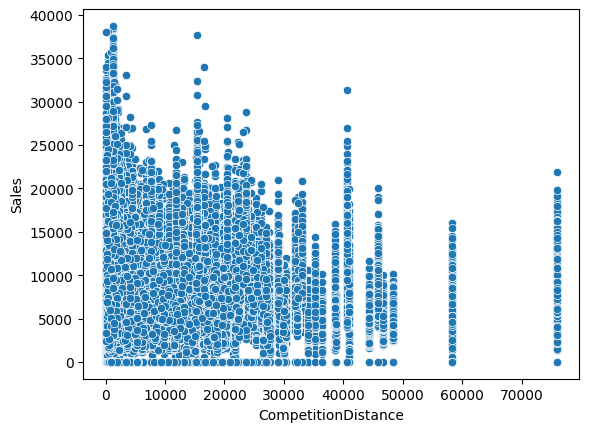

In [ ]:
sns.scatterplot(x=data['CompetitionDistance'], y=data['Sales'])

**Reason for choosing the above chart:**

Scatter plot is used because here we have two continuous variables namely **'Sales'** and **'CompetitionDistance'**.

**Observations:**

* As the CompetitionDistance decreases Sales increases.
* Most stores have competition distance within the range of 0 to 20 kms and had more sales than stores far away probably indicating competition in busy locations vs remote locations.

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

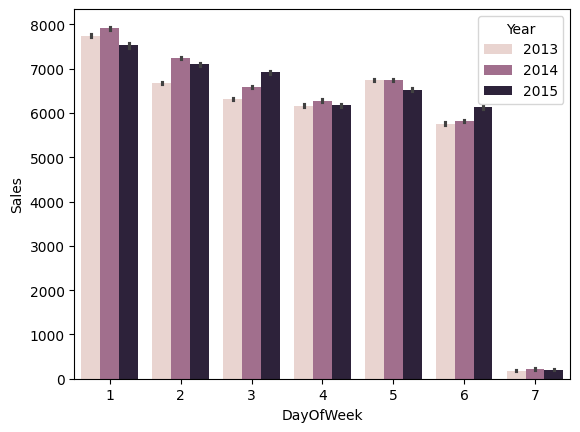

In [ ]:
sns.barplot(x=data["DayOfWeek"],y=data['Sales'],hue=data["Year"])


**Reason for choosing the above chart:**

We are considering **'DayOfWeek'** as a categorical feature and **'Sales'** as numeric and continuous variable hence we considered bar plot.

**Observations:**

* The Overall trend of Sales v/s DayOfWeek is same in all years of the given data.
* Sales are made more in 'Monday' and it get decrease by the end of week.
* Moreover sales are made more in the year 2014.

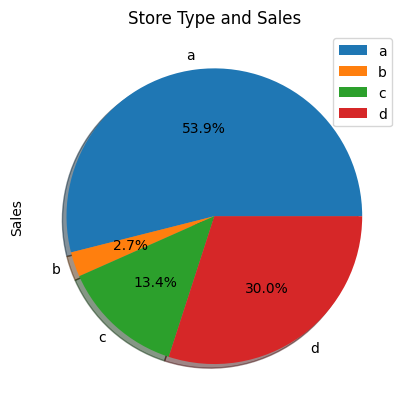

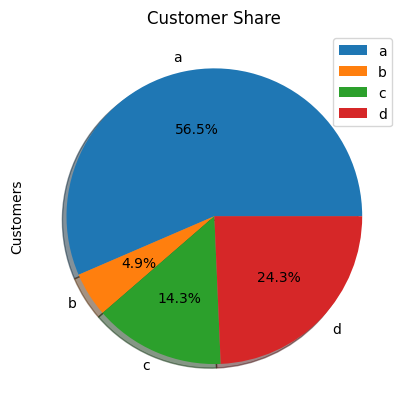

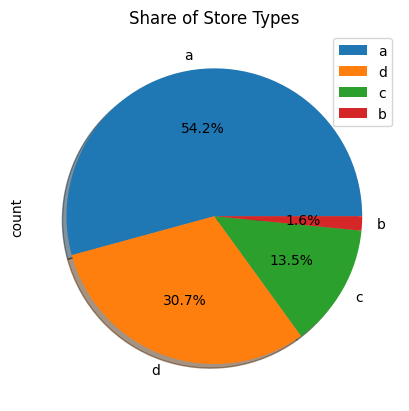

In [ ]:
data.groupby("StoreType")["Sales"].sum().plot.pie(title='Store Type and Sales', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()
#customers and store type
data.groupby("StoreType")["Customers"].sum().plot.pie(title='Customer Share', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()
#store types in all of the dataset
data["StoreType"].value_counts().plot.pie(title='Share of Store Types', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()

**Reason for choosing the above chart:**

Pie chart is used to find the contribution of each **StoreType** in overall **Sales** and **Customers** in the entire data.

**Observations:**

* It can be clearly observed that the highest sales belonged to the store type **'a'** due to the high number of type **'a'** stores in our dataset. Store type **'a'** and **'c'** had a similar kind of sales and customer share.
* We can see that store type **'b'** with highest average sales and per store revenue generation looks healthy and a reason for that would be all three kinds of assortment strategies involved which was seen earlier.

**Correlation Matrix**

<Axes: title={'center': 'Pearson Correlation of Features'}>

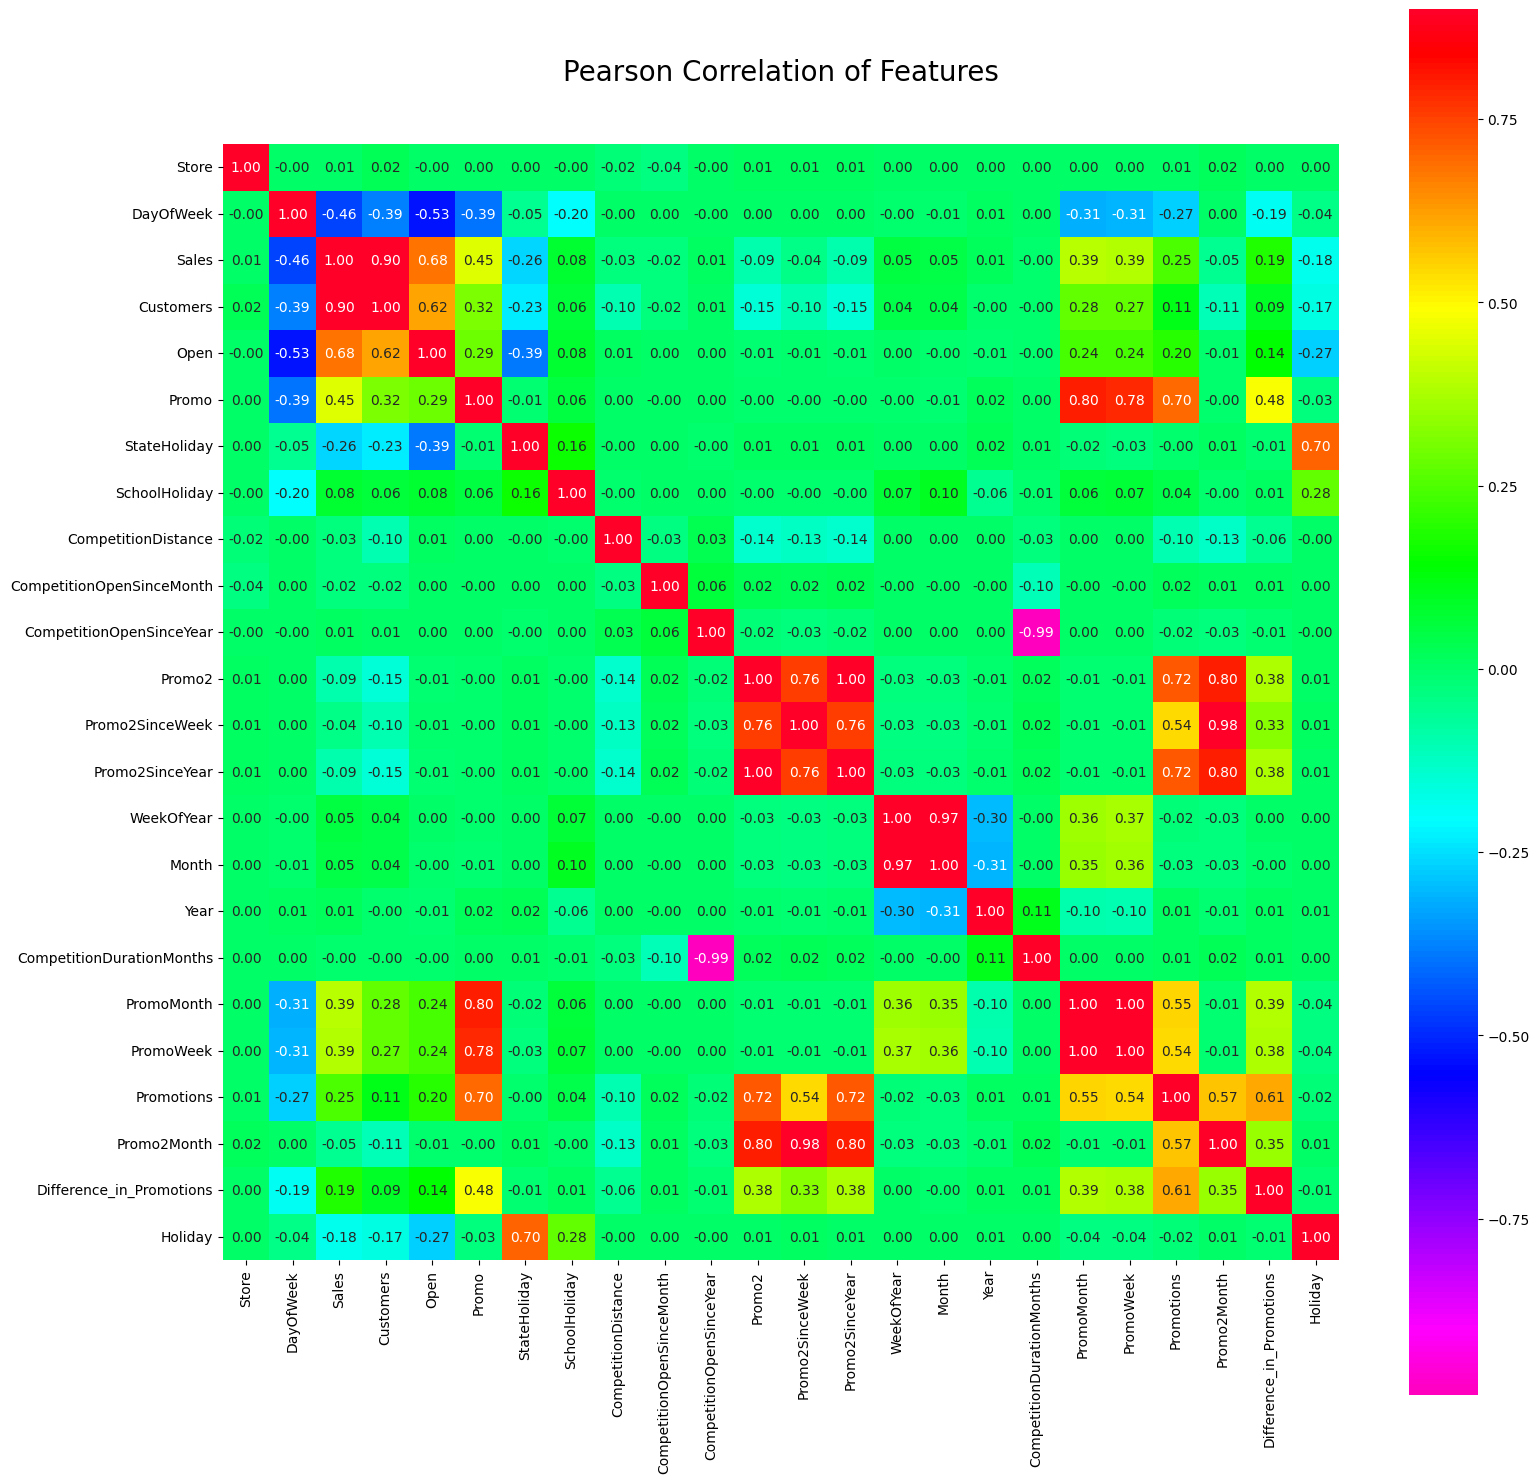

In [ ]:
numeric_data = data.select_dtypes(include=[np.number])
corr_mat = numeric_data.corr()
colormap = plt.cm.RdBu
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(corr_mat,annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.9, square=True,cmap='gist_rainbow_r')

**Observation:**
* Day of the week has a negative correlation indicating low sales as the weekends, and promo, customers and open has positive correlation.
State Holiday has a negative correlation suggesting that stores are mostly closed on state holidays indicating low sales.
* CompetitionDistance showing negative correlation suggests that as the distance increases sales reduce, which was also observed through the scatterplot earlier.
* There's multicollinearity involved in the dataset as well. The features telling the same story like Promo2, Promo2 since week and year are showing multicollinearity.
* The correlation matrix is agreeing with all the observations done earlier while exploring through barplots and scatterplots.

## **Hypothesis Testing**

---



It is very obvious that the data we are dealing with is a time series data. So there is a possibility that the data may contain **Non-Stationarity**.


Let's see if we can find any sufficient evidence to reject the above Hypothesis.

In [ ]:
#  Function to test if any unit root is present in the dataset

from statsmodels.tsa.stattools import adfuller
def adf_test(data):
  # Perform Augmented Dickey-Fuller test
  adf_test = adfuller(data['Sales'])

  # Display the p-value
  print("p-value of ADF test is", adf_test[1])


In [ ]:
#  Performing Time serise analysis through visual inspection..
#  The below defined function takes the data frame and the StoreType as inputs and decompose the daily sales pattern of a specific StoreType into Trend, Season and Residuals...
#  It finally checks the p-value for each set of data and tells if there is any unit root present..

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

def perform_time_series_analysis(data,store_type):
  sales_data = data[['Date','StoreType','Sales']]

  df = sales_data[(sales_data.StoreType == store_type)]
  df.set_index('Date', inplace=True)
  df = df.resample('D').sum()
  # Perform seasonal decomposition
  decomposition = seasonal_decompose(df['Sales'], model='additive')
  avg_sales = df['Sales'].mean()

  # Plot original time series
  plt.figure(figsize=(14, 12))
  plt.subplot(411)
  plt.plot(df.index, df['Sales'], label='Original')
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.xlabel('Year')
  plt.ylabel('Sales')
  plt.title(f'Sales Over Time - Store Type: "{store_type}"')
  plt.legend()

  # Plot trend component
  plt.subplot(412)
  plt.plot(df.index, decomposition.trend, label='Trend')
  # plt.axhline(y=decomposition.trend.mean(), color='r', linestyle='--', label='Average')
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.xlabel('Year')
  plt.ylabel('Trend')
  plt.legend()

  # Plot seasonal component
  plt.subplot(413)
  plt.plot(df.index, decomposition.seasonal, label='Seasonal')
  # plt.axhline(y=decomposition.trend.mean(), color='r', linestyle='--', label='Average')
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.xlabel('Year')
  plt.ylabel('Seasonal')
  plt.legend()

  # Plot residual component
  plt.subplot(414)
  plt.plot(df.index, decomposition.resid, label='Residual')
  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.xlabel('Year')
  plt.ylabel('Residual')
  plt.legend()

  plt.tight_layout()
  plt.show()
  print('*'*30)
  adf_test(df)

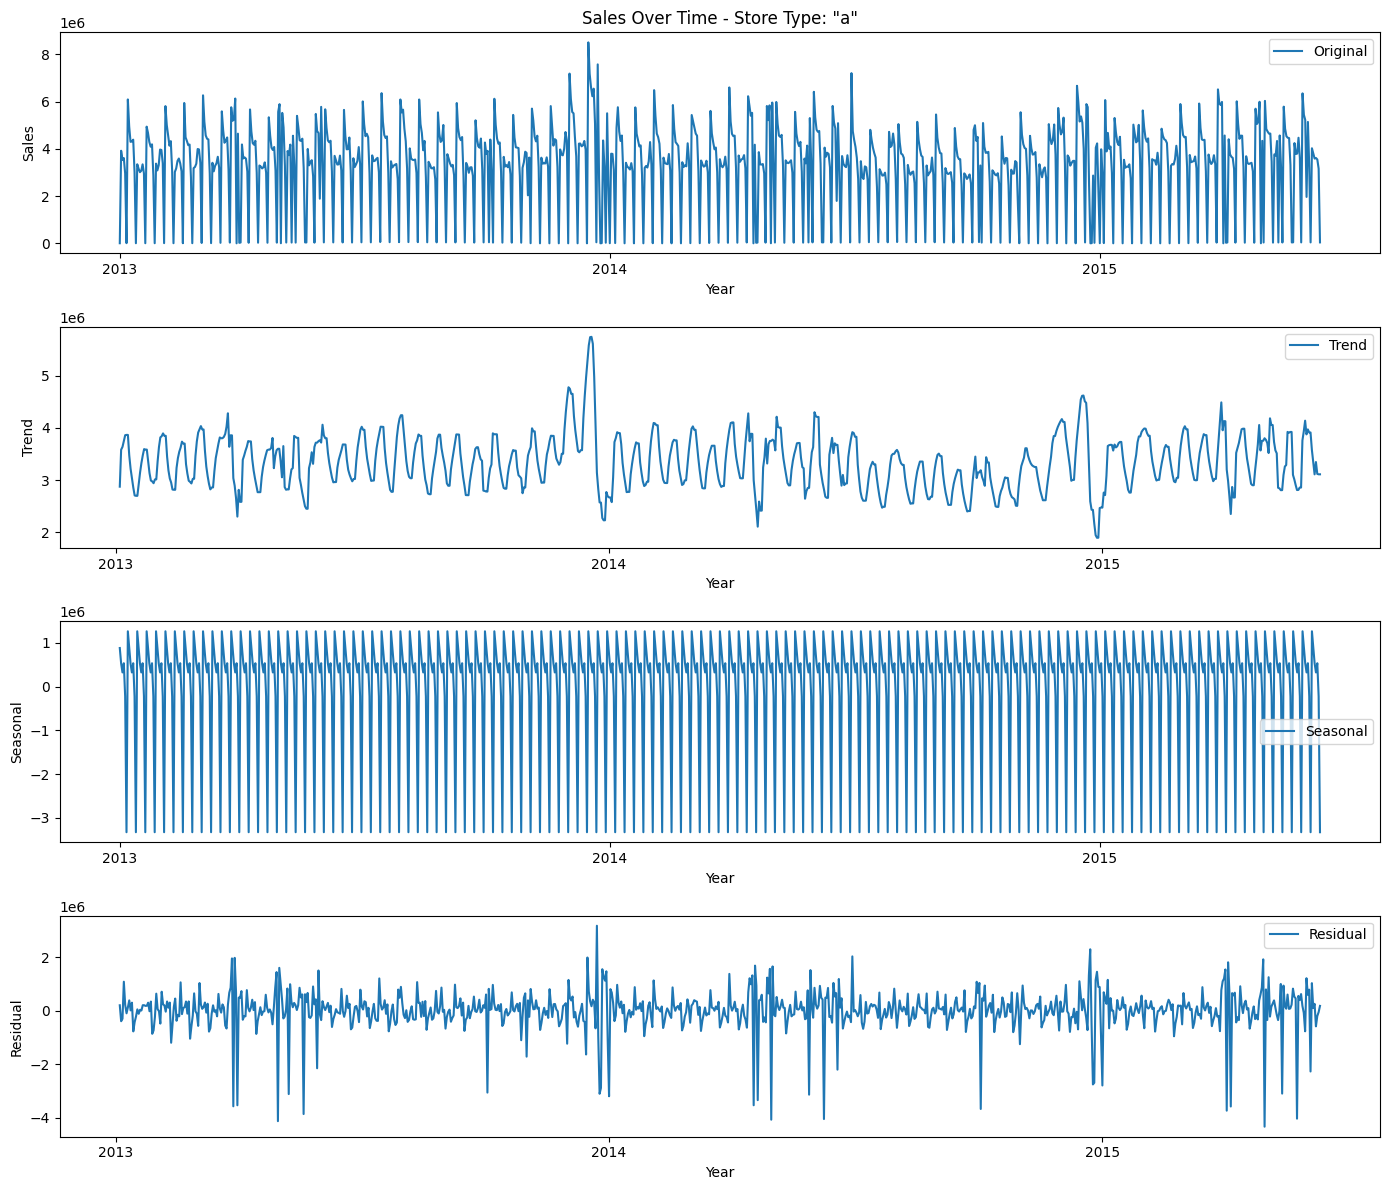

******************************
p-value of ADF test is 1.2147500430215796e-05


In [ ]:
perform_time_series_analysis(data,'a')

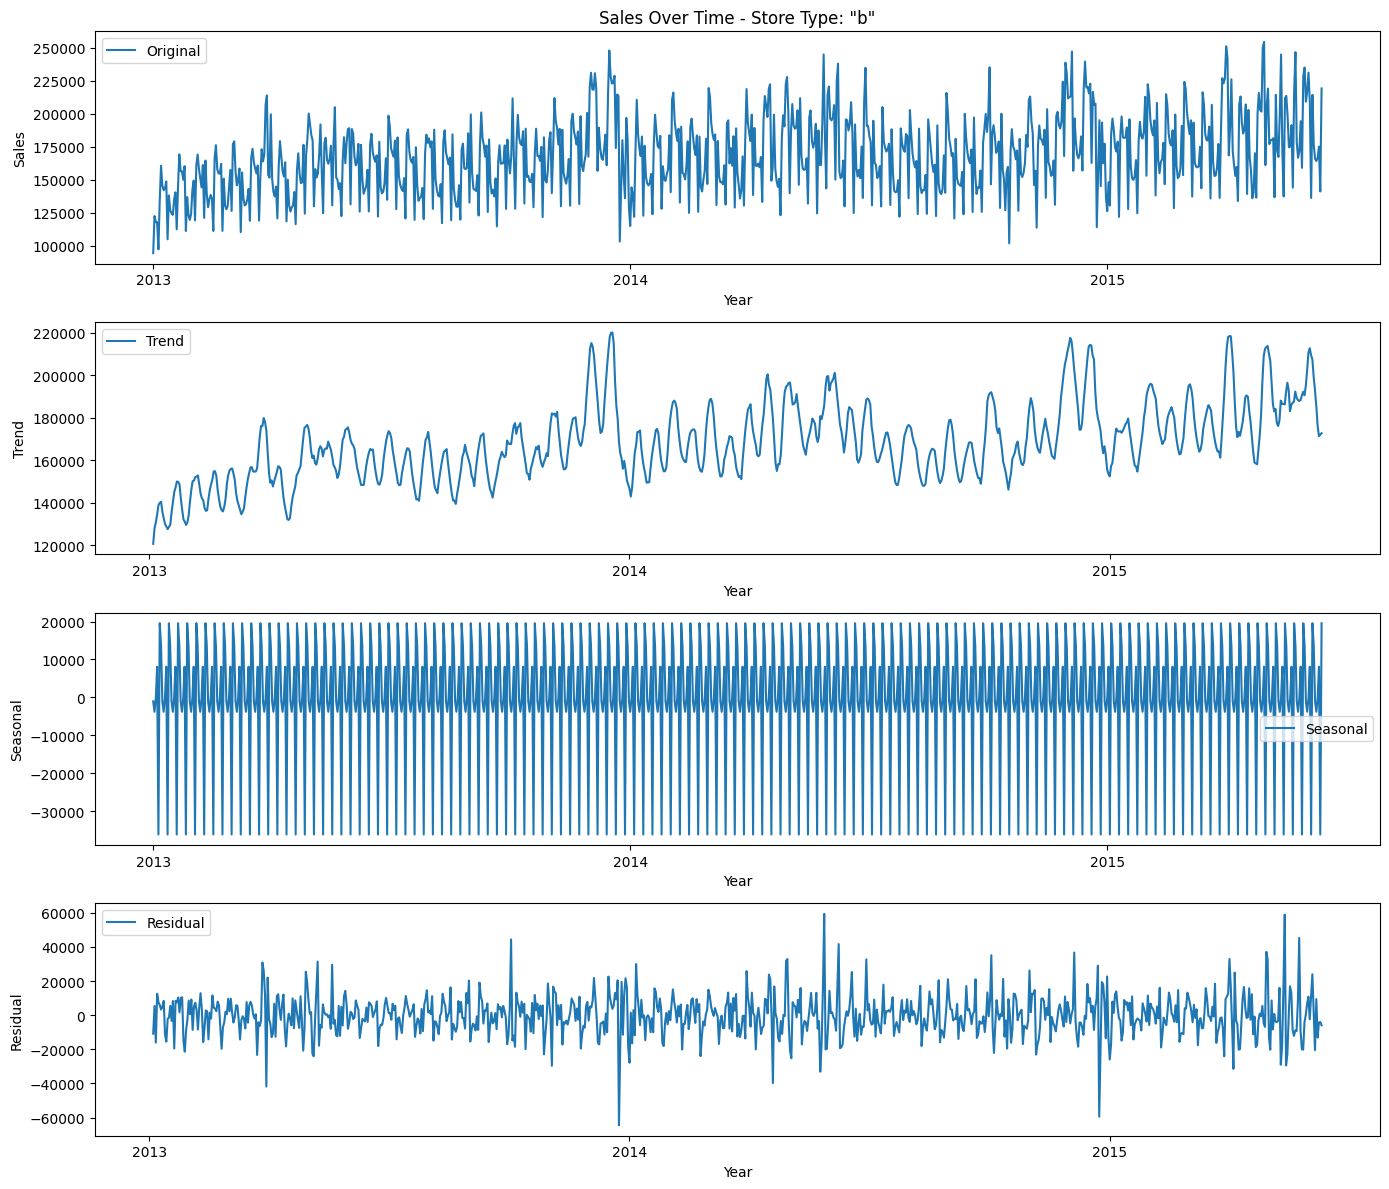

******************************
p-value of ADF test is 0.005324135929293299


In [ ]:
perform_time_series_analysis(data,'b')

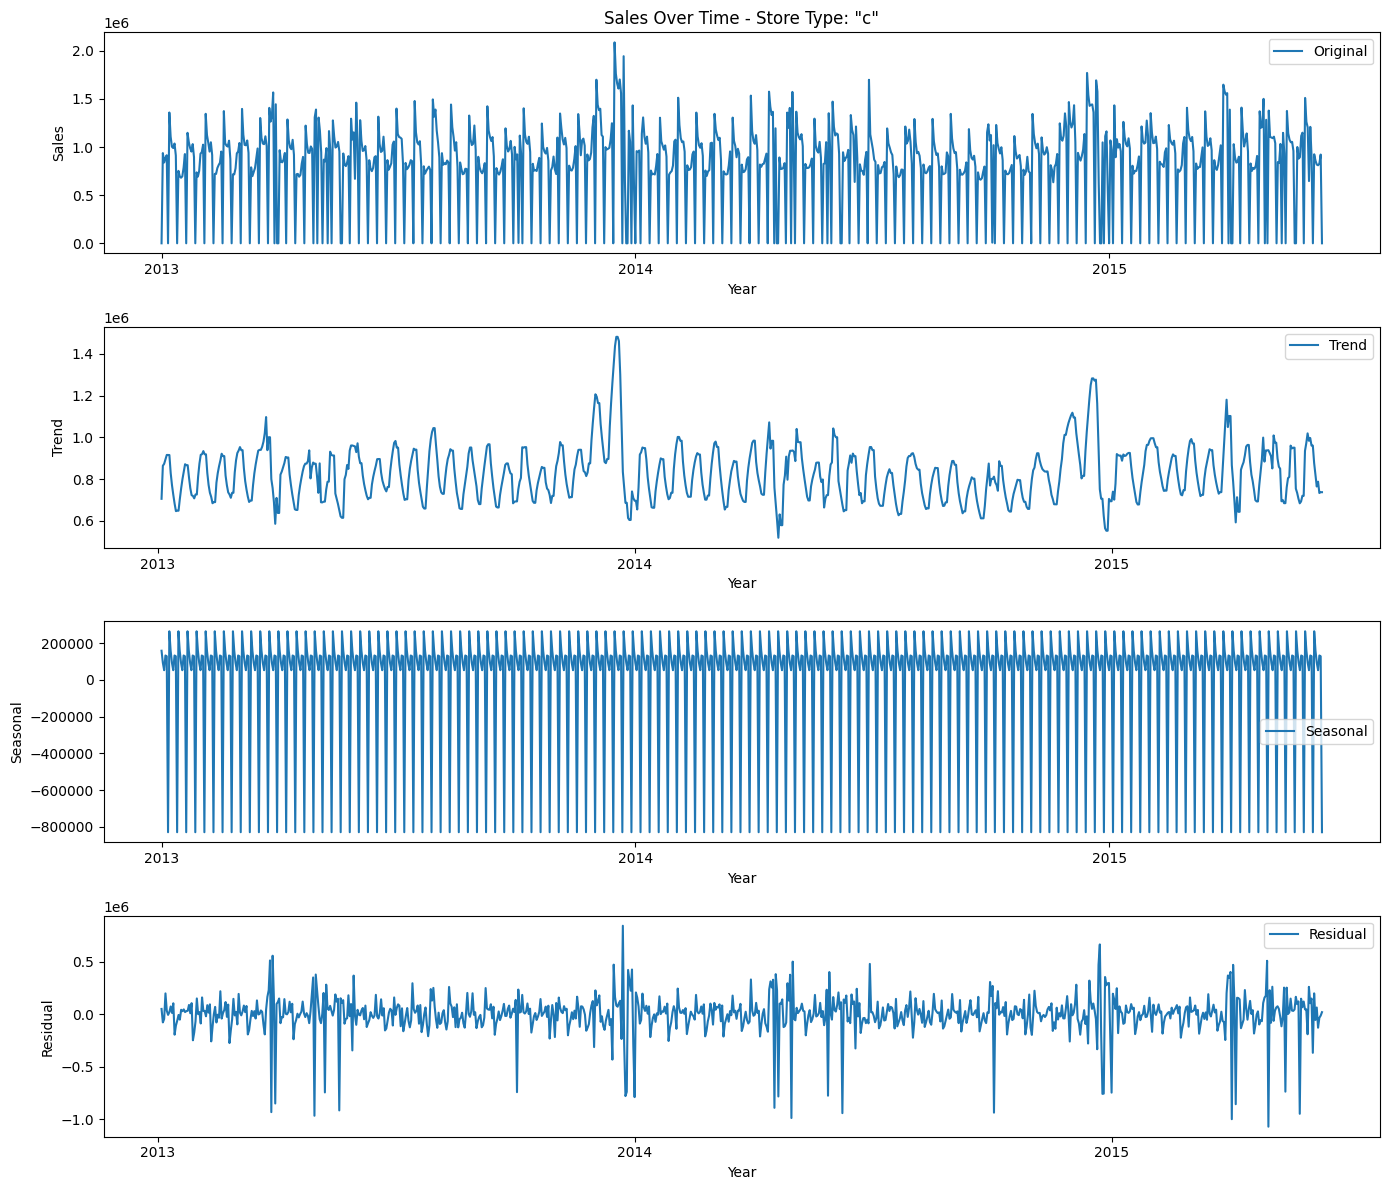

******************************
p-value of ADF test is 4.963642952403185e-06


In [ ]:
perform_time_series_analysis(data,'c')

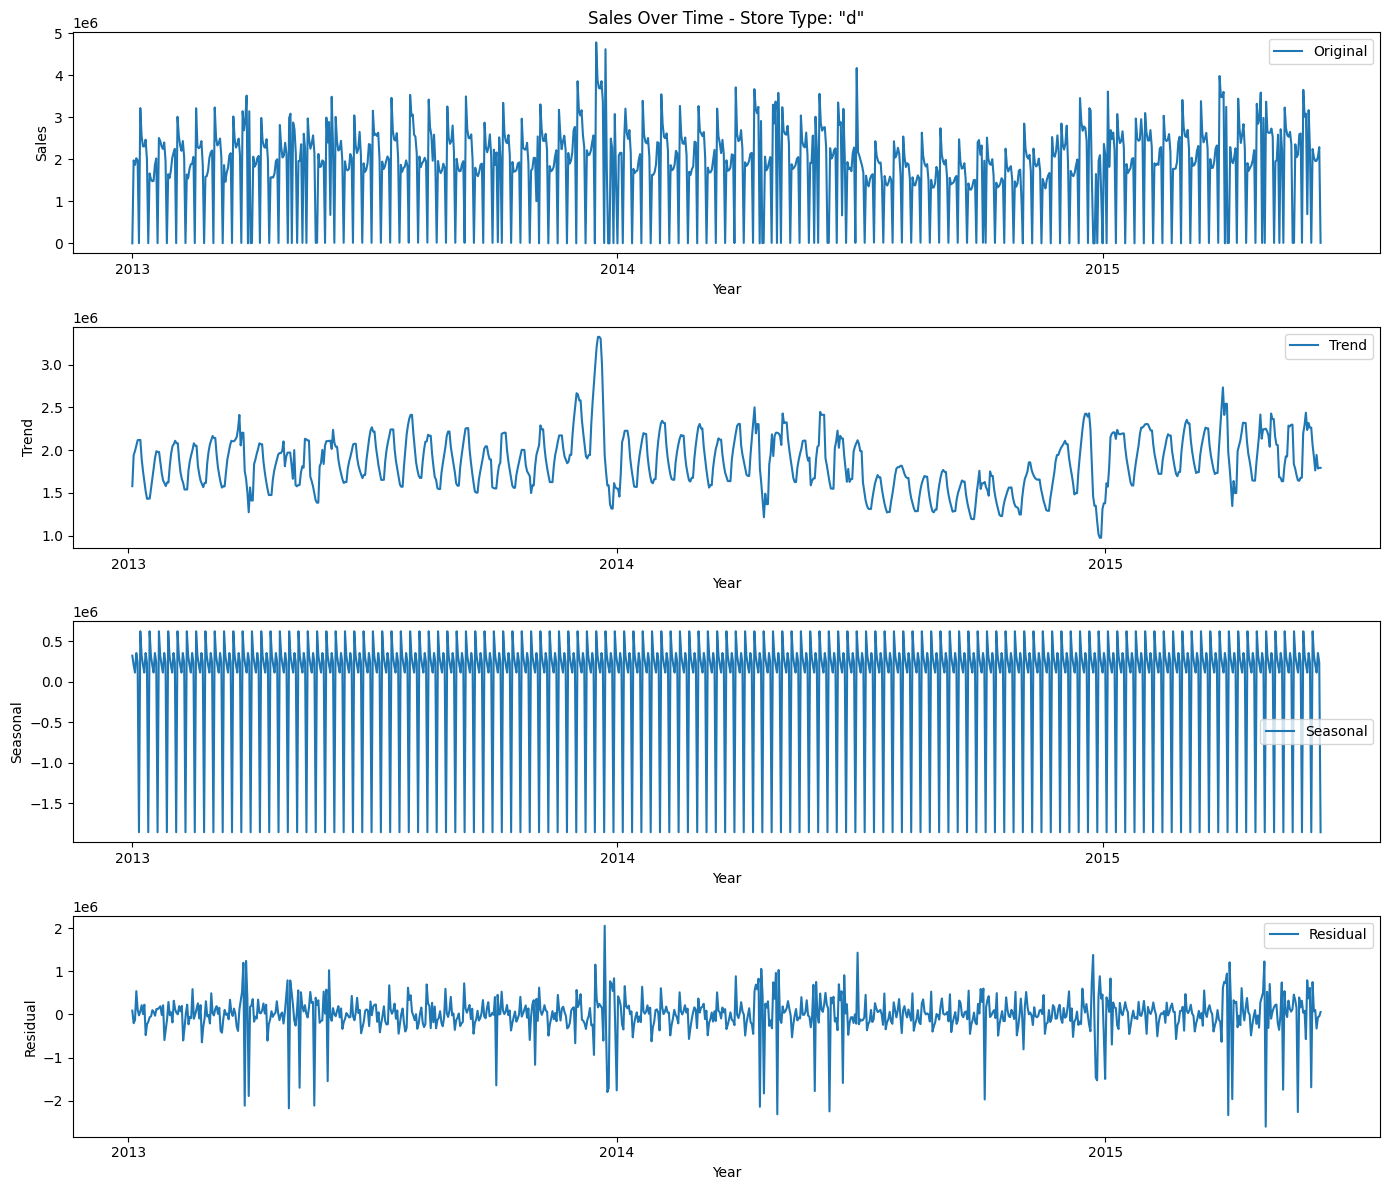

******************************
p-value of ADF test is 0.0031376282462099317


In [ ]:
perform_time_series_analysis(data,'d')

From the above analysis we can see that the p-value of each subset of data(based on StoreType) is significantly low enough to ignore. Hence we can disprove the claimed hypothesis. Therefore the data is Stationary.

##**Data Preparation for Modelling**

**Outlier Detection and Treatment**

At first we will be seperating the categorical and numerical features and then we will be trying to remove outliers from each feature of the categories if needed.

In [ ]:
# Finding categorical variables
categorical = [i for i in data.columns if data[i].dtypes=='O']
print('Total Categorical columns: ',len(categorical))
print(categorical)
print('**'*30)
# Finding Numeric variable
numeric = [i for i in data.columns if data[i].dtypes!='O']
print('Total Numerical columns: ',len(numeric))
print(numeric)

Total Categorical columns:  3
['StoreType', 'Assortment', 'PromoInterval']
************************************************************
Total Numerical columns:  25
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'WeekOfYear', 'Month', 'Year', 'CompetitionDurationMonths', 'PromoMonth', 'PromoWeek', 'Promotions', 'Promo2Month', 'Difference_in_Promotions', 'Holiday']


In [ ]:
for col in numeric:
  print("number of unique values in {} is: {}".format(col,len(data[col].unique())))

number of unique values in Store is: 1115
number of unique values in DayOfWeek is: 7
number of unique values in Date is: 895
number of unique values in Sales is: 21549
number of unique values in Customers is: 4073
number of unique values in Open is: 2
number of unique values in Promo is: 2
number of unique values in StateHoliday is: 2
number of unique values in SchoolHoliday is: 2
number of unique values in CompetitionDistance is: 654
number of unique values in CompetitionOpenSinceMonth is: 12
number of unique values in CompetitionOpenSinceYear is: 23
number of unique values in Promo2 is: 2
number of unique values in Promo2SinceWeek is: 25
number of unique values in Promo2SinceYear is: 8
number of unique values in WeekOfYear is: 52
number of unique values in Month is: 12
number of unique values in Year is: 3
number of unique values in CompetitionDurationMonths is: 331
number of unique values in PromoMonth is: 13
number of unique values in PromoWeek is: 41
number of unique values in Pro

Creating a list of **continuous_cols** and **discerte_num_cols** from **numeric**

In [ ]:
continuous_cols = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionDurationMonths']
print('Continuous variables: ',continuous_cols)
discrete_num_cols = ['Promo', 'Holiday', 'Promo2', 'DayOfWeek','WeekOfYear','SchoolHoliday', 'Promotions', 'Open', 'StateHoliday']
print('Discrete variables:',discrete_num_cols)

Continuous variables:  ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionDurationMonths']
Discrete variables: ['Promo', 'Holiday', 'Promo2', 'DayOfWeek', 'WeekOfYear', 'SchoolHoliday', 'Promotions', 'Open', 'StateHoliday']


Performing outlier detection on continuous numeric list of features through visual inspection.

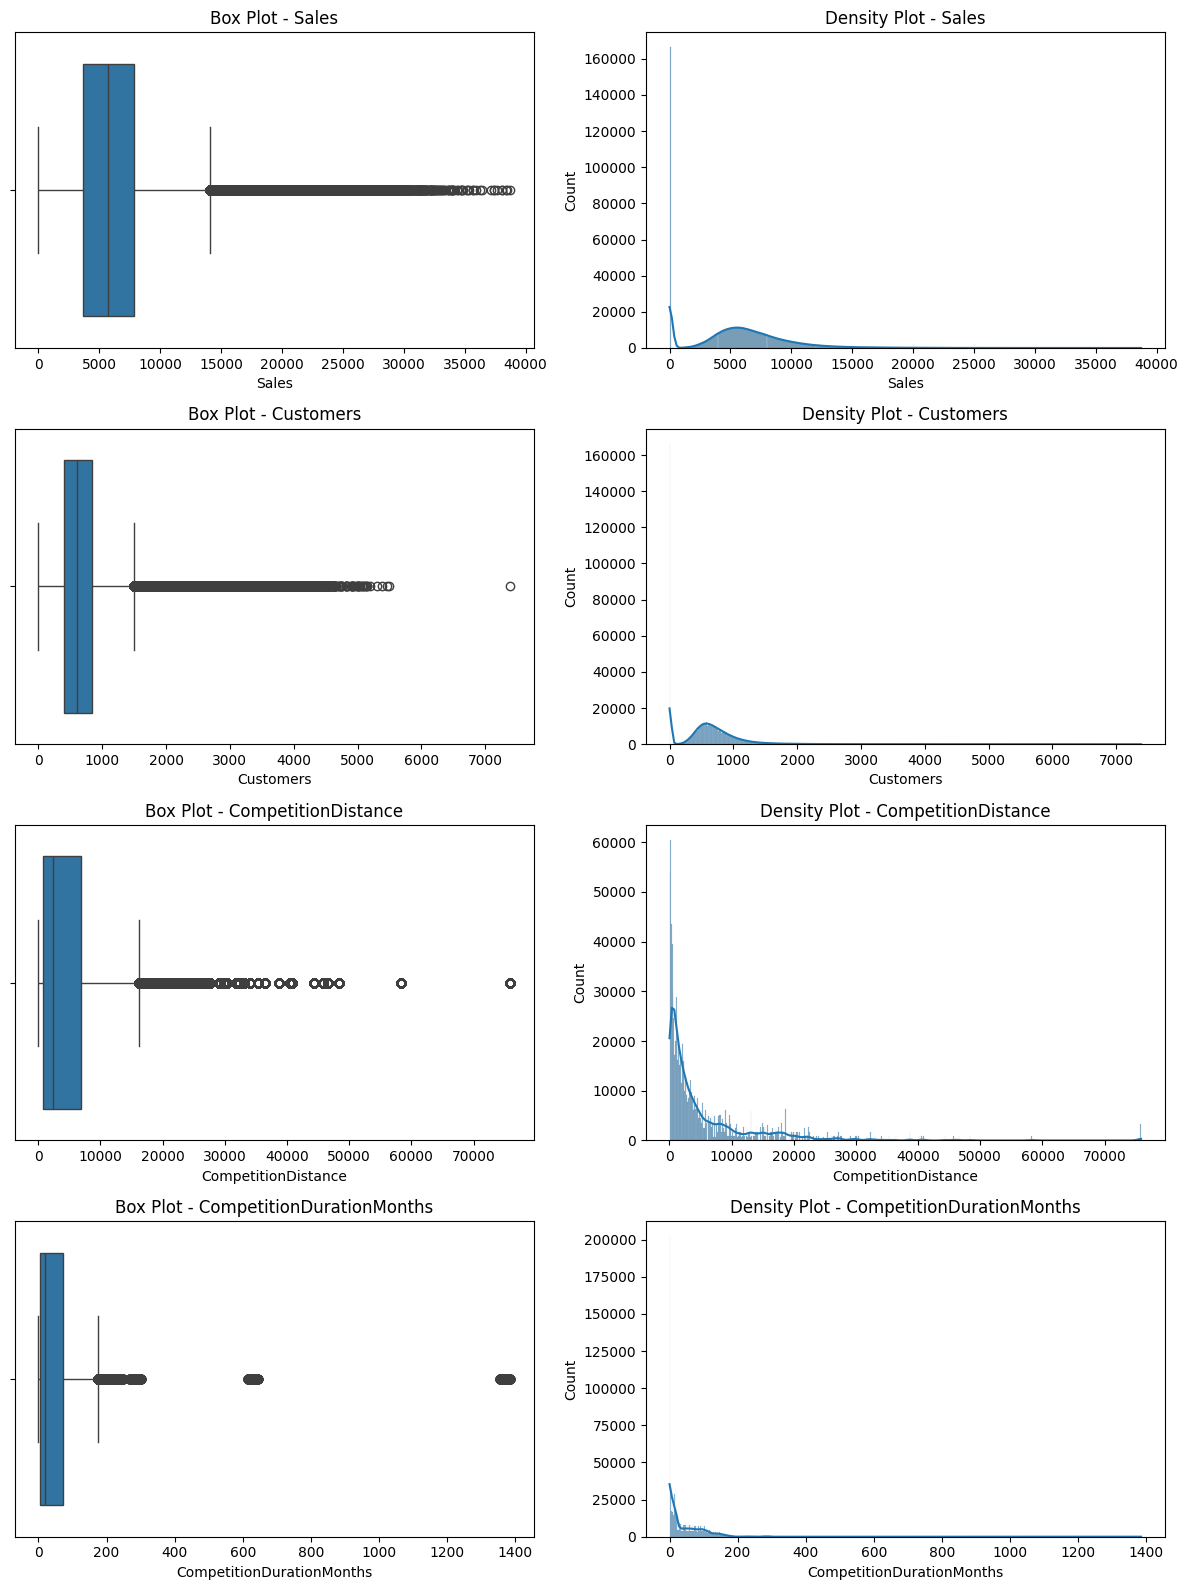

In [ ]:
show_box_density_plot(data,continuous_cols)

We can see that most of the continuous numerical features contains outliers.Inorder to remove outliers from the continuous numeric features we will be using IQR method.

In [ ]:
data[continuous_cols].skew()

Sales                        0.644248
Customers                    1.587335
CompetitionDistance          3.597716
CompetitionDurationMonths    7.998405
dtype: float64

In [ ]:
outliers_in_features = ['Customers','CompetitionDistance','CompetitionDurationMonths']
for i in outliers_in_features:
  print(outlier_bounderies_percent(data,i))

(-254.5, 1493.5, '3.7%')
(-8590.0, 16210.0, '9.83%')
(-98.0, 174.0, '1.48%')


 We will be removing these outliers from the Continuous numerical features later on..

In [ ]:
new_df = data.copy()

In [ ]:
new_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
52405      1          7 2015-06-14      0          0     0      0   
52406      2          7 2015-06-14      0          0     0      0   
52407      3          7 2015-06-14      0          0     0      0   
52408      4          7 2015-06-14      0          0     0      0   
52409      5          7 2015-06-14      0          0     0      0   

       StateHoliday  SchoolHoliday StoreType  ... WeekOfYear  Month  Year  \
52405             0              0         c  ...         24      6  2015   
52406             0              0         a  ...         24      6  2015   
52407             0              0         a  ...         24      6  2015   
52408             0              0         c  ...         24      6  2015   
52409             0              0         a  ...         24      6  2015   

       CompetitionDurationMonths  PromoMonth  PromoWeek  Promotions  \
52405                         81           0          0           0   
52406                         91           0          0           1   
52407                        102           0          0           1   
52408                         69           0          0           0   
52409                          2           0          0           0   

      Promo2Month  Difference_in_Promotions  Holiday  
52405           0                         0        0  
52406           4                         0        0  
52407           4                         0        0  
52408           0                         0        0  
52409           0                         0        0  

[5 rows x 28 columns]

Performing outlier detection on categorical list of features through inspection.

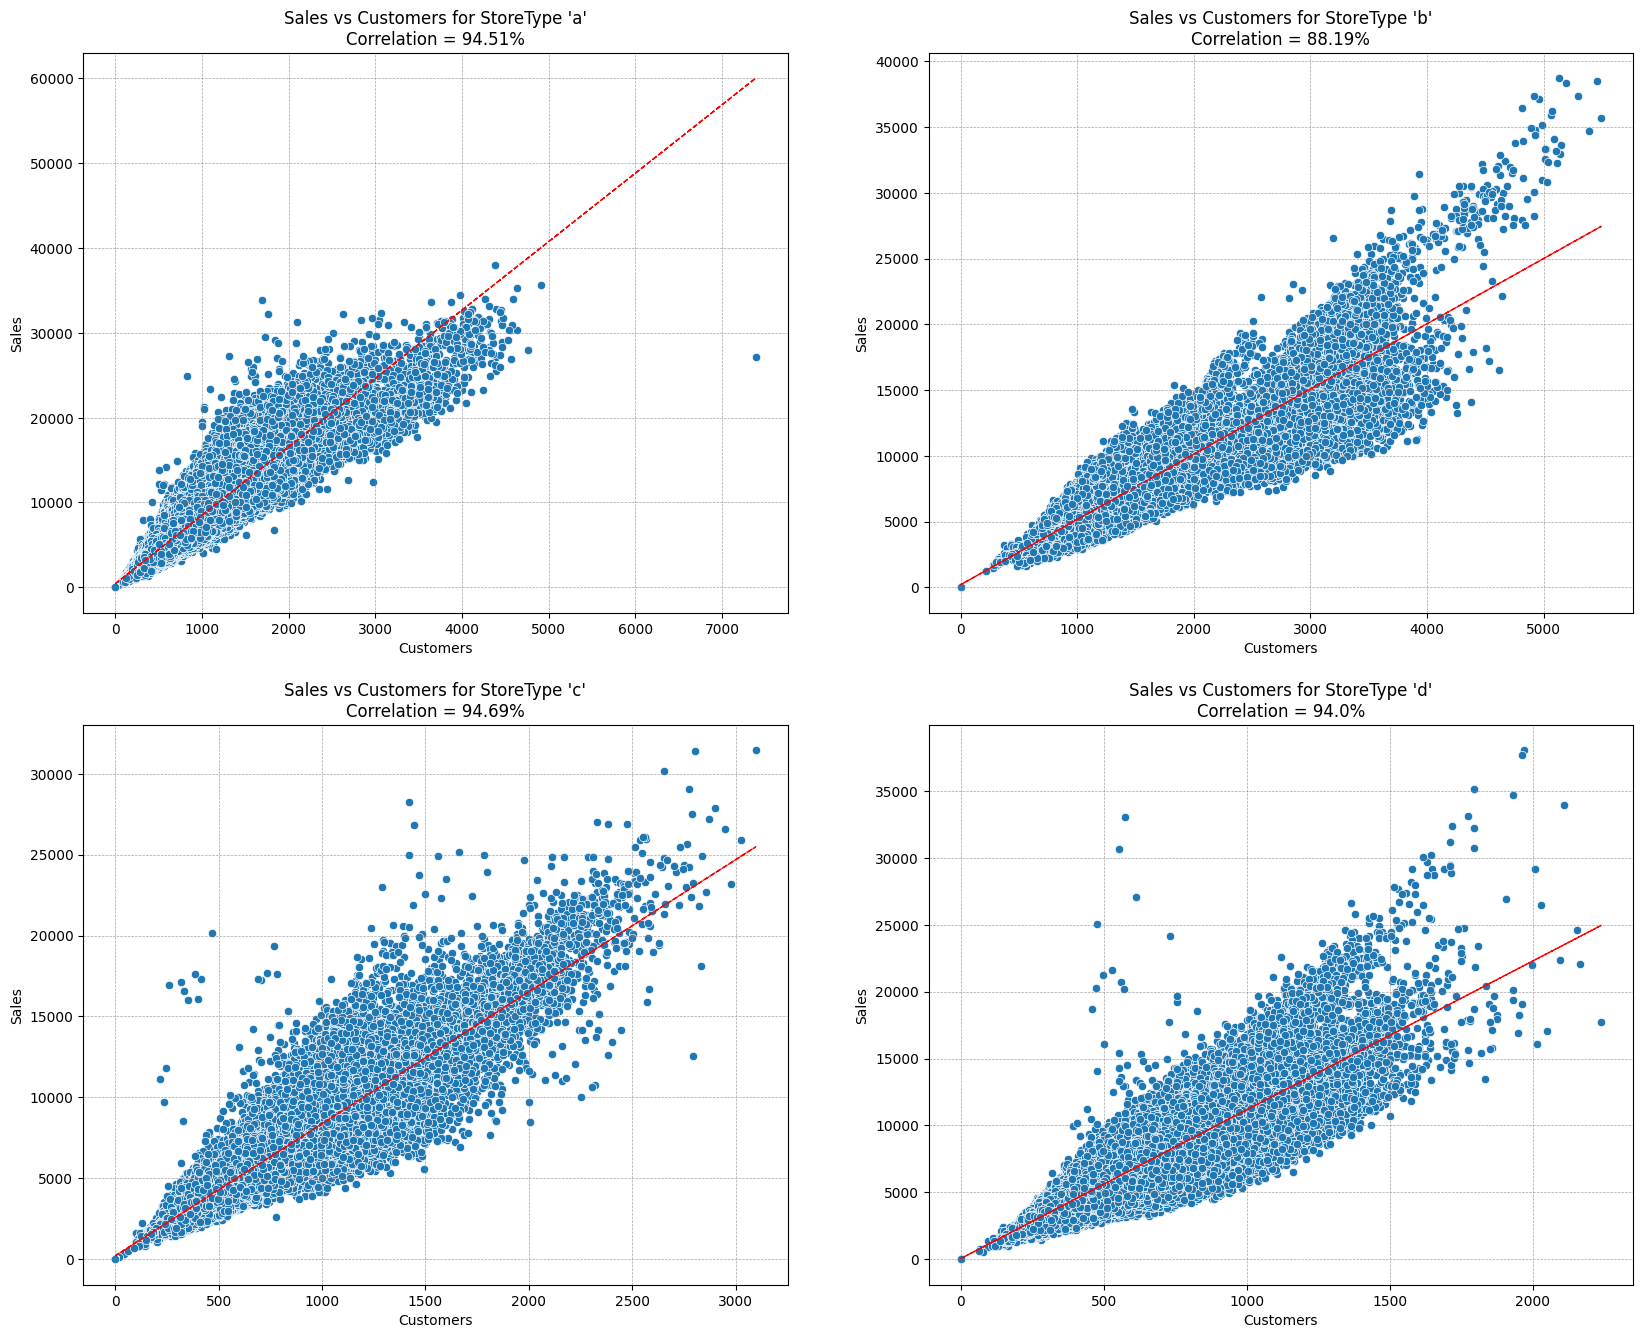

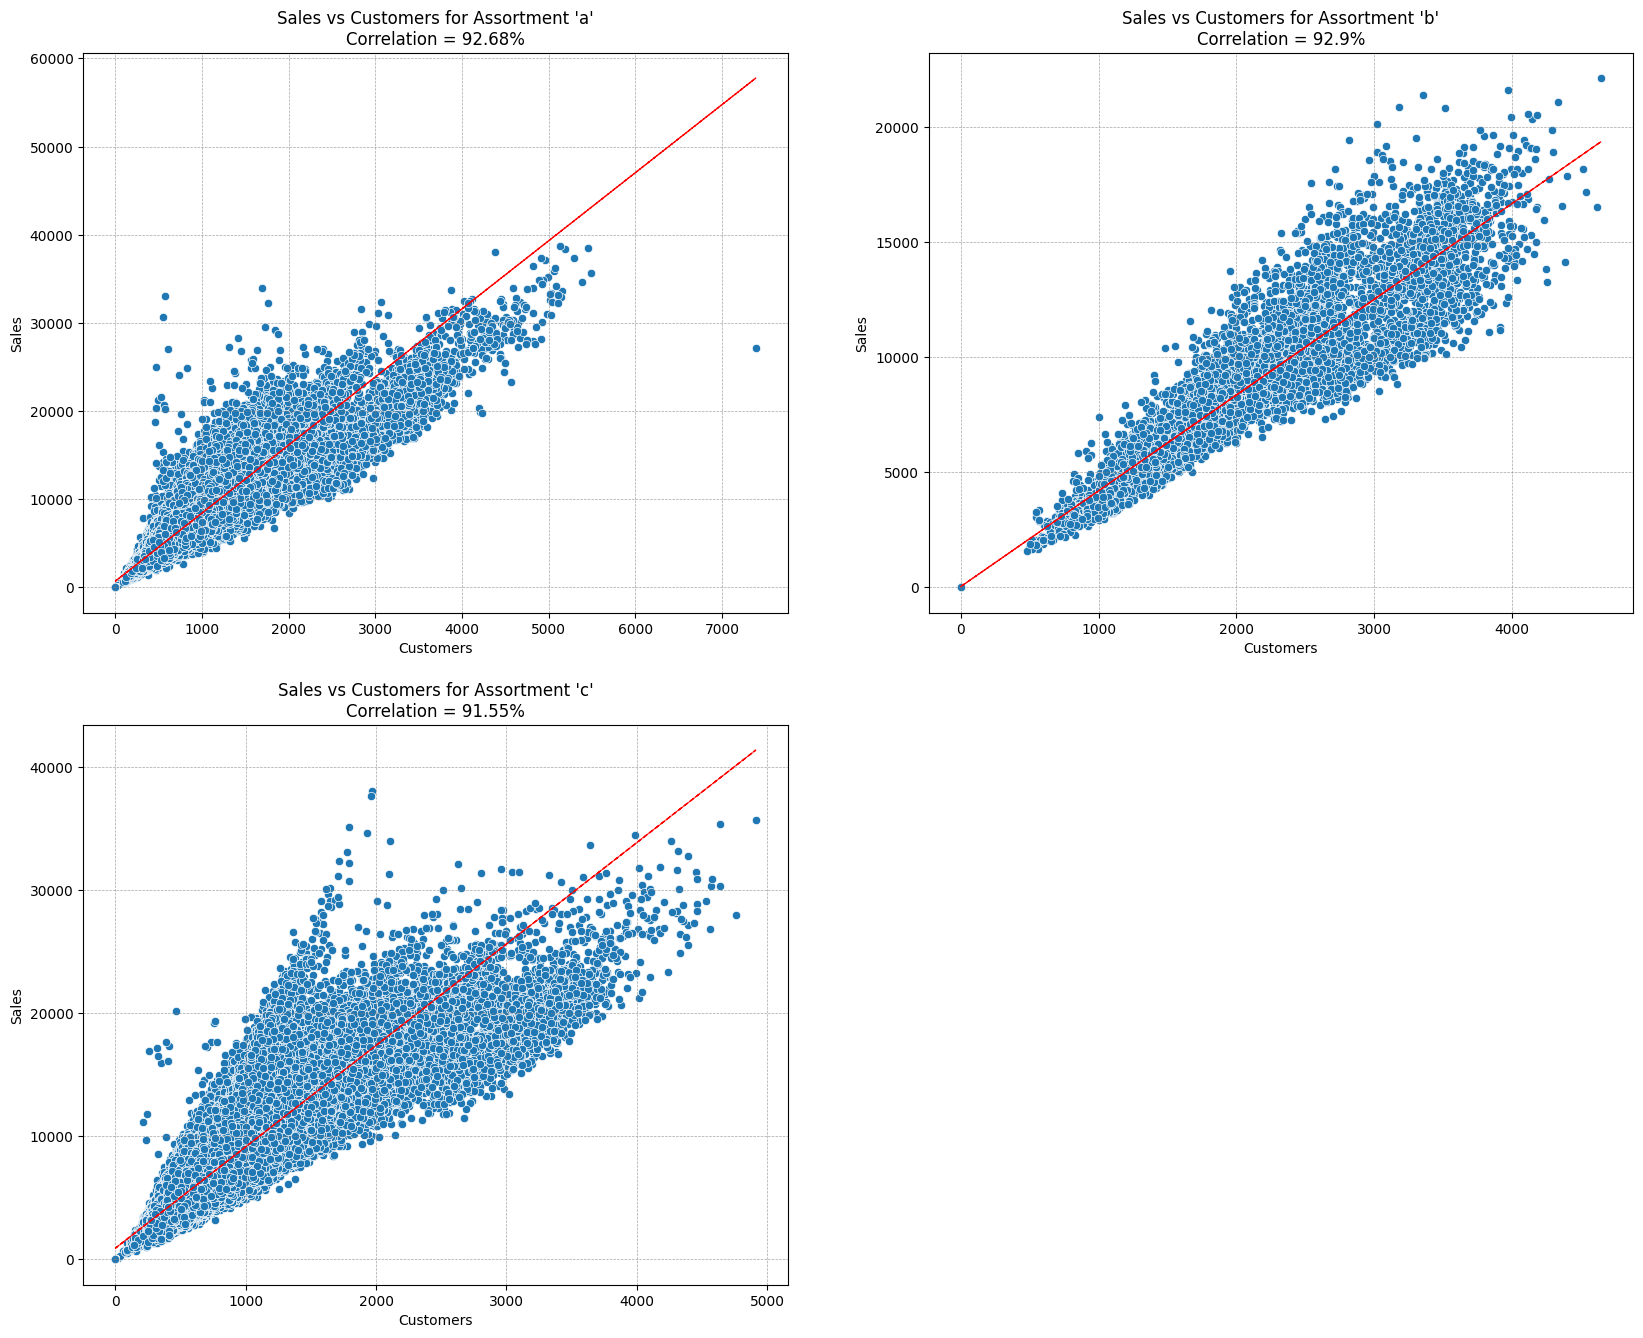

In [ ]:
categorical_features = ['StoreType', 'Assortment']

for i in categorical_features:
  sales_customers_vs_categorical_variable(new_df, i)


**Filter for Categorical Features**

* Removing outliers from **'new_df'** based on Categorical features.

In [ ]:
def Store_type_outliers_index(df):
  req_indexes = df[((df['StoreType']=='a')&((df.Customers>7000)|((df.Customers<2000)&(df.Sales>30000))))
|((df['StoreType']=='b')&(df.Customers>=5500))|
 ((df['StoreType']=='c')&((df.Customers>2750)|((df.Customers<500)&(df.Sales>9900))|
  (((df.Customers>500)&(df.Customers<1500))&(df.Sales>25000))))
|((df['StoreType']=='d')&(((df.Customers<500)&(df.Sales>14800))|((df.Customers>500)&(df.Customers<1000))&(df.Sales>17500)))].index

  return req_indexes

def Assortment_type_outlier_index(df):
  req_indexes = df[((df['Assortment']=='a')&((
     ((df.Customers<1000)&(df.Sales>23000))|(((df.Customers>1000)&(df.Customers<2000))&(df.Sales>=23000)))))|
    ((df['Assortment']=='c')&
     (((df.Customers<500)&(df.Sales>8500))|(((df.Customers>=1800)&(df.Customers<2000))&(df.Sales>=30000))|
     (((df.Customers>2000)&(df.Customers<=2300))&(df.Sales>30000))))].index
  return req_indexes


In [ ]:
new_df.drop(Store_type_outliers_index(new_df),inplace=True)
new_df.drop(Assortment_type_outlier_index(new_df),inplace=True)
new_df.shape

(964667, 28)

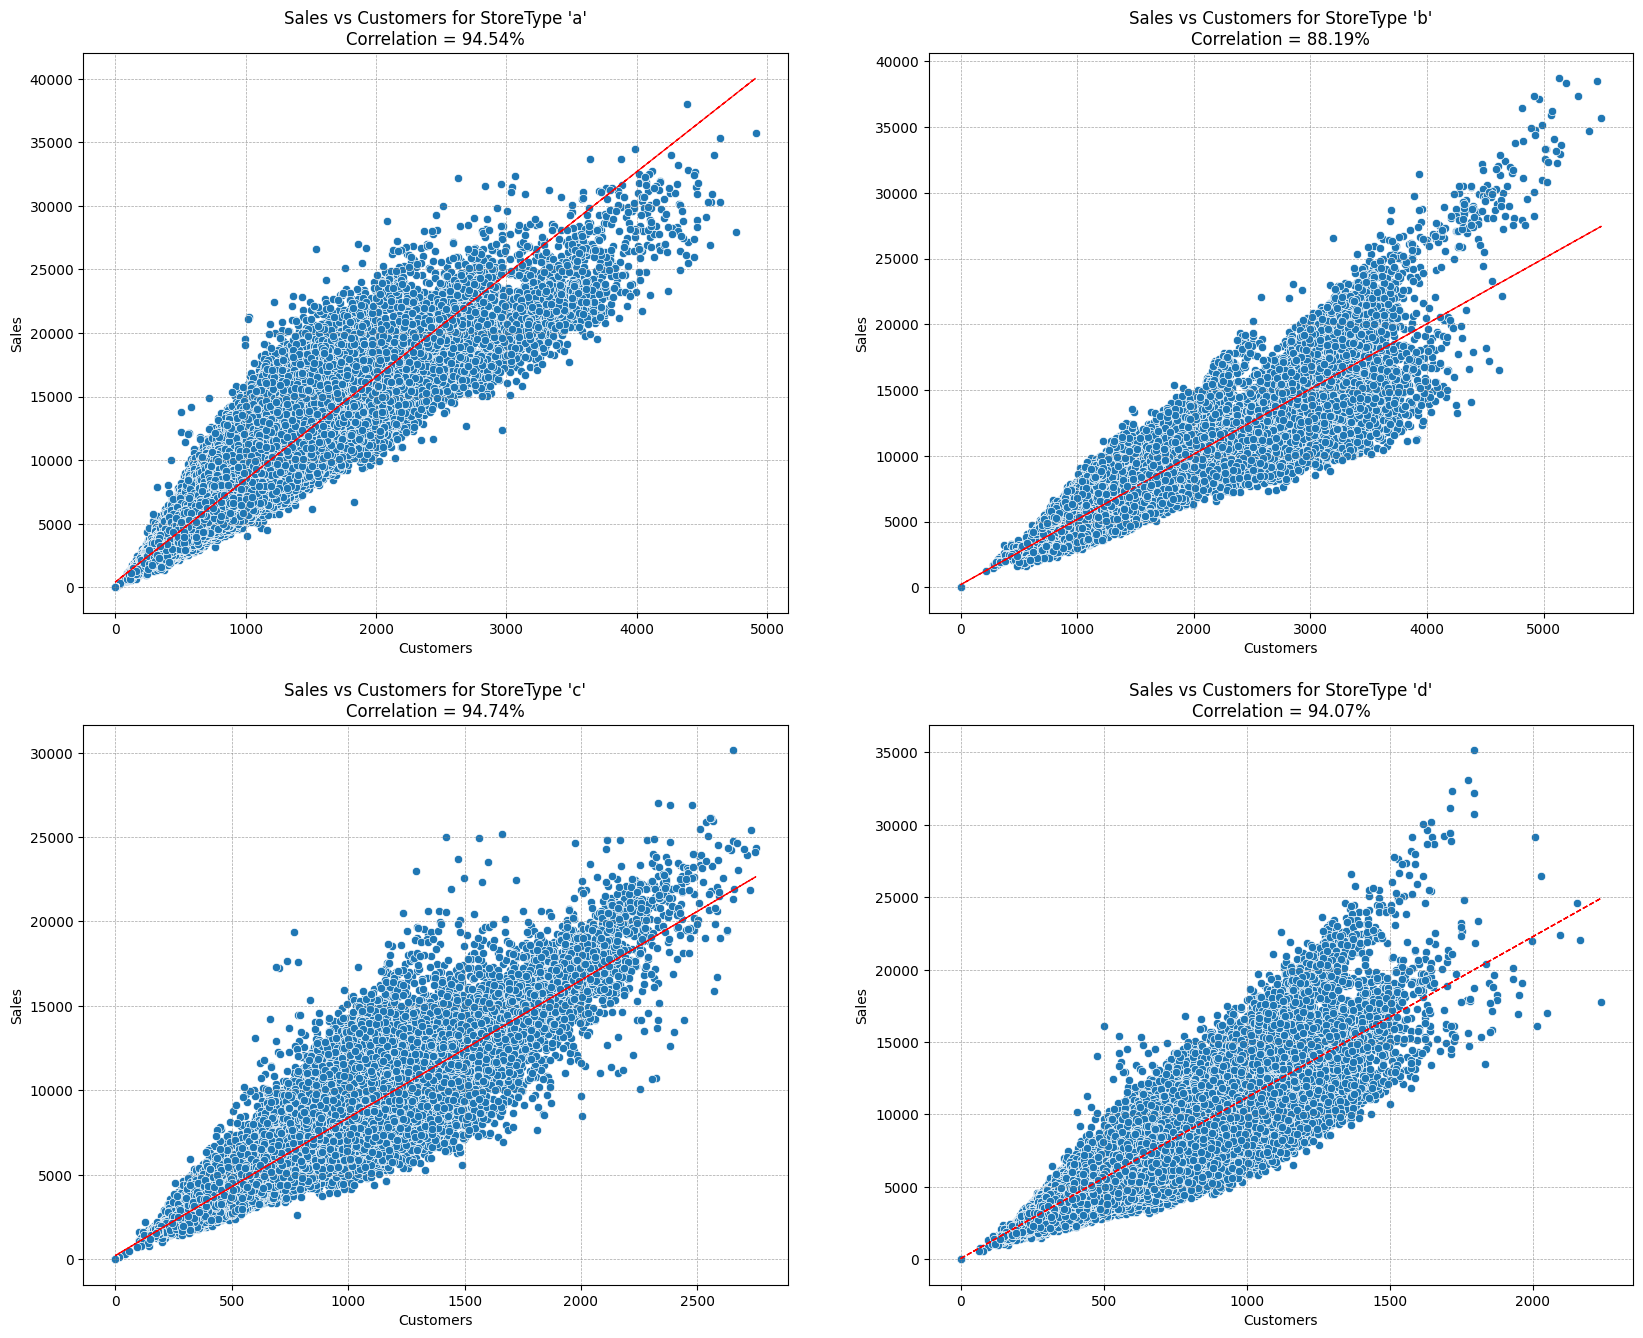

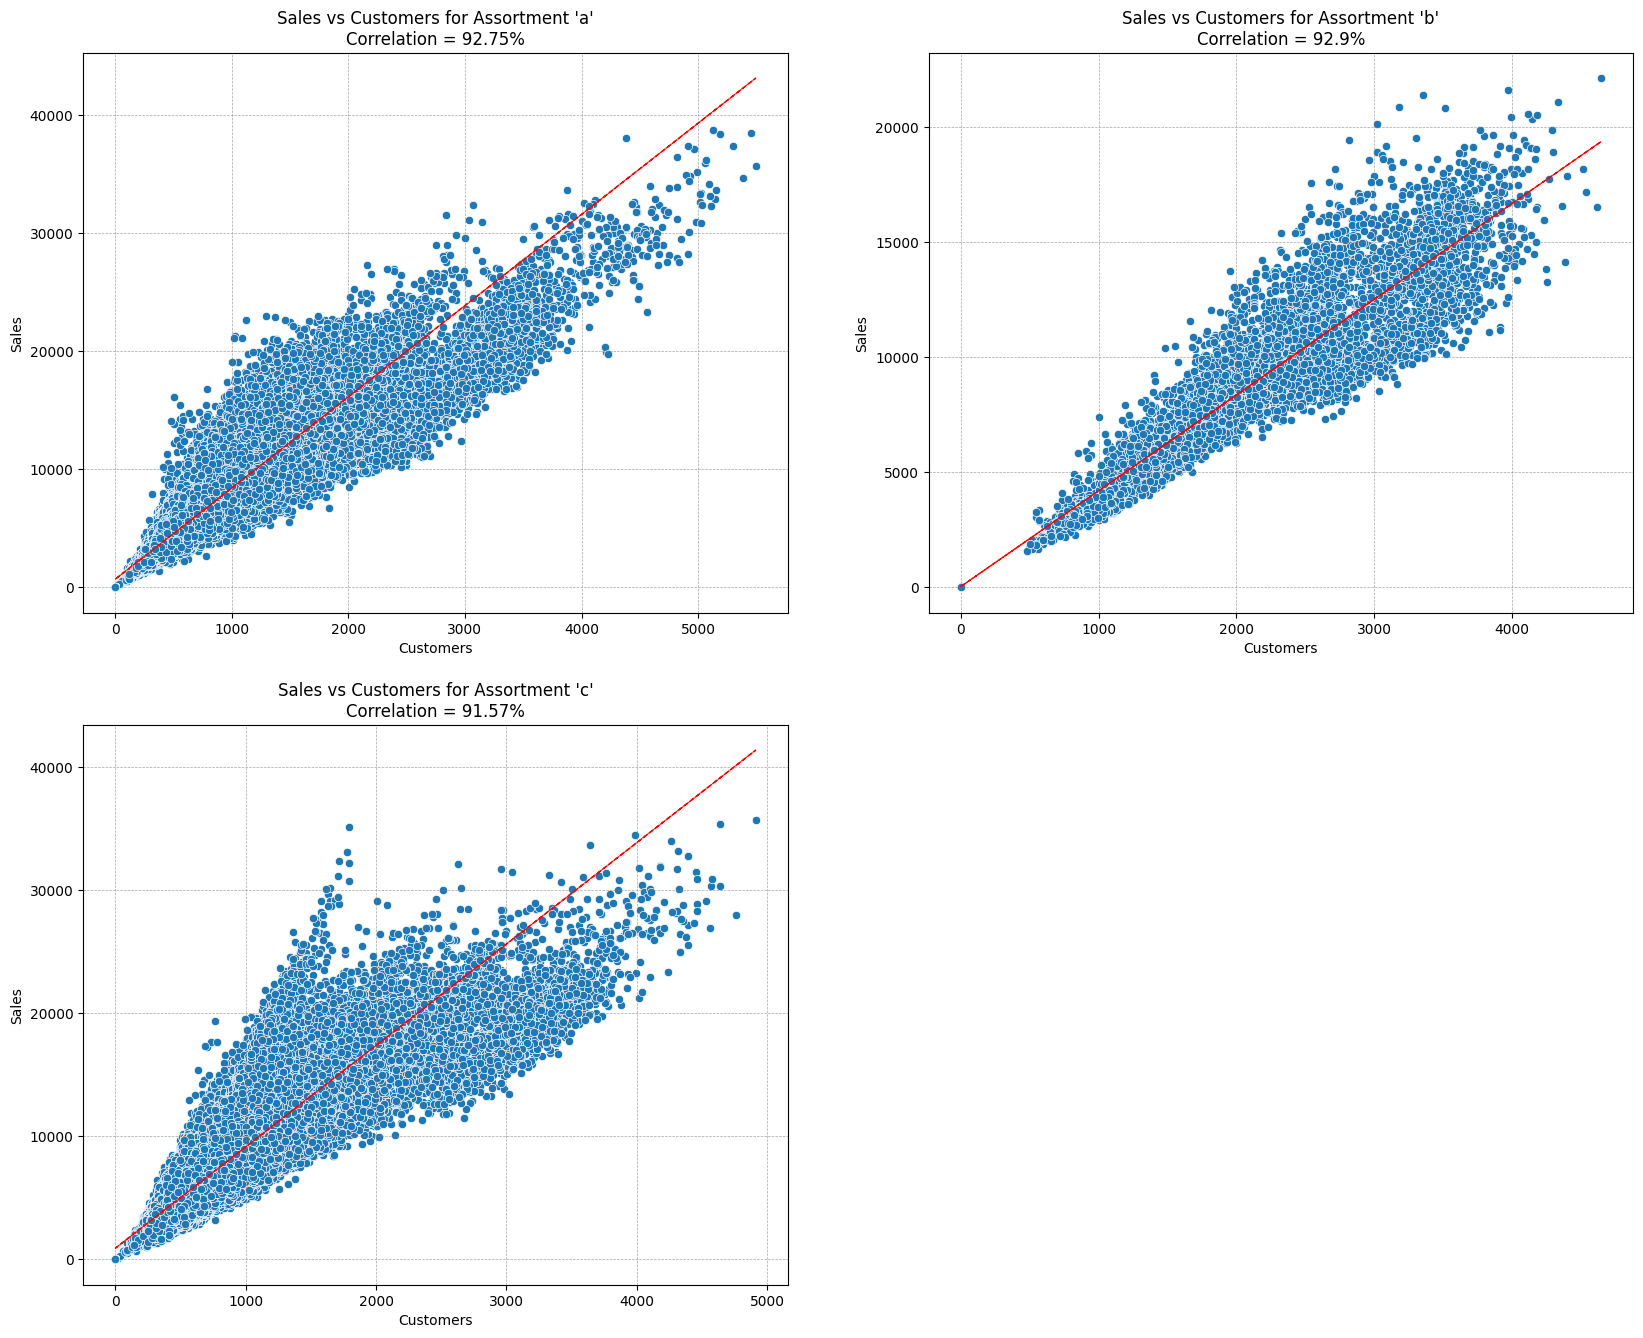

In [ ]:
for i in categorical_features:
  sales_customers_vs_categorical_variable(new_df, i)

* Removing outliers from **'unseen_data'** based on Categorical features.

In [ ]:
unseen_data.drop(Store_type_outliers_index(unseen_data),inplace=True)
unseen_data.drop(Assortment_type_outlier_index(unseen_data),inplace=True)
unseen_data.shape

(52392, 28)

Finding the outlier bounderies for numerical features...

In [ ]:
outliers_in_features = ['Customers','CompetitionDistance','CompetitionDurationMonths']
for i in outliers_in_features:
  print(outlier_bounderies_percent(new_df,i))

(-254.5, 1493.5, '3.69%')
(-8590.0, 16210.0, '9.83%')
(-98.0, 174.0, '1.48%')


 We can see that around **9.75%** of the values in the **CompetitionDistance** are outliers hence its better not to drop all of them as this would lead to loss of data.

**Filter for Numerical features**

In [ ]:
new_df = new_df[((new_df.Customers>=0) & (new_df.Customers<=1485))&
               ((new_df.CompetitionDurationMonths>=0) & (new_df.CompetitionDurationMonths<=175))]

unseen_data = unseen_data[((unseen_data.Customers>=0) & (unseen_data.Customers<=1485))&
                         ((unseen_data.CompetitionDurationMonths>=0) & (unseen_data.CompetitionDurationMonths<=175))]

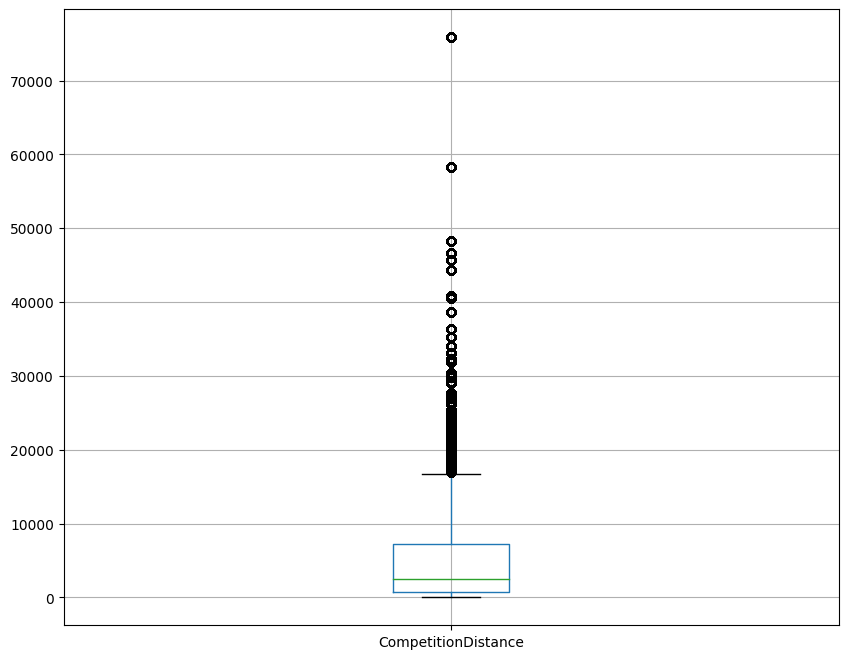

In [ ]:
show_box_plot(new_df,['CompetitionDistance'],10,8)

 Since we can not eleminate entire outliers from the **CompetitionDistance** feature as this may overfit the model hence we will eleminate values beyond certain range say **30000-40000**.

In [ ]:
for val in [30000,32000,35000,36000,37000,37500,38000,40000,42000]:
  count = new_df[new_df['CompetitionDistance'] > val].shape[0]
  percent = round(count/new_df.shape[0]*100, 2)
  print(f"Count & percentage of data above {val} : {count} ({percent}%)")

Count & percentage of data above 30000 : 19256 (2.1%)
Count & percentage of data above 32000 : 16573 (1.81%)
Count & percentage of data above 35000 : 13107 (1.43%)
Count & percentage of data above 36000 : 12212 (1.33%)
Count & percentage of data above 37000 : 11317 (1.24%)
Count & percentage of data above 37500 : 11317 (1.24%)
Count & percentage of data above 38000 : 11317 (1.24%)
Count & percentage of data above 40000 : 9530 (1.04%)
Count & percentage of data above 42000 : 7806 (0.85%)


**Keeping only data which contains CompetitionDistance <= 37000**

In [ ]:
new_df = new_df[(new_df.CompetitionDistance>0)&(new_df.CompetitionDistance<=37000)]

unseen_data = unseen_data[(unseen_data.CompetitionDistance>0)&(unseen_data.CompetitionDistance<=37000)]

In [ ]:
new_df.shape,unseen_data.shape

((903834, 28), (48700, 28))

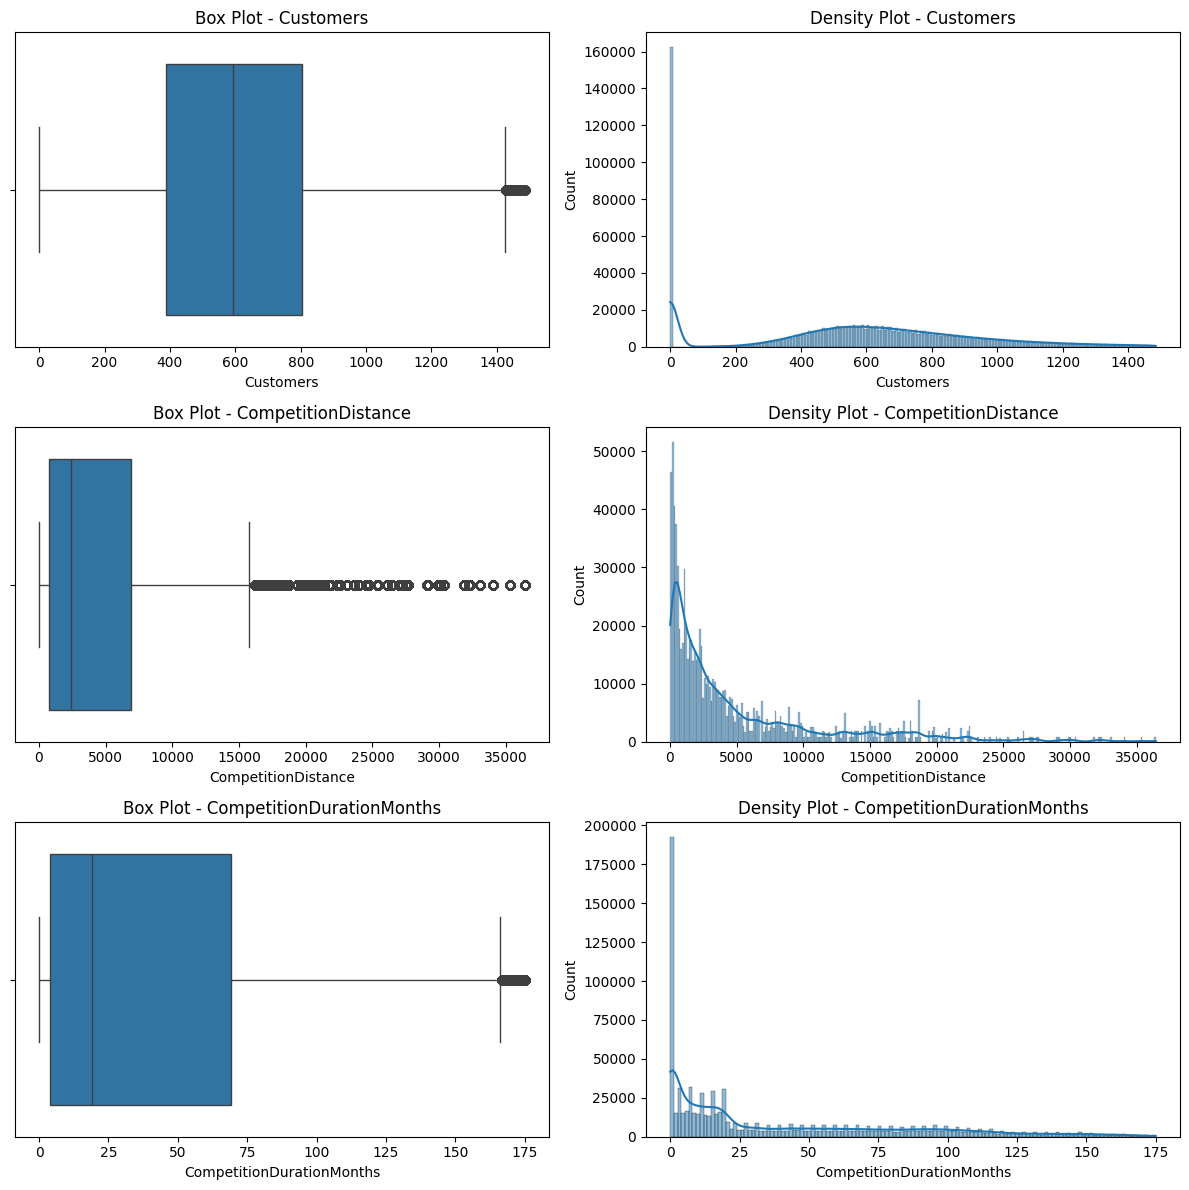

In [ ]:
show_box_density_plot(new_df,outliers_in_features)

 We can see that there are still outliers in the above continuous variables but **removing all the outliers** from the above features may **overfit** the model.

**Removing Refurbishment based data**

In [ ]:
refurbishment_index = [i for i in refurbishment_data_indices if i in new_df.index]

print('Number of records in new_df with stores under refurbishment is: ',len(refurbishment_index))

Number of records in new_df with stores under refurbishment is:  147463


In [ ]:
new_df.drop(refurbishment_index,inplace = True)
new_df.shape

(756371, 28)

In [ ]:
refurbishment_index = [i for i in refurbishment_data_indices if i in unseen_data.index]

print('Number of records in new_df with stores under refurbishment is: ',len(refurbishment_index))

Number of records in new_df with stores under refurbishment is:  6327


In [ ]:
unseen_data.drop(refurbishment_index,inplace = True)
unseen_data.shape

(42373, 28)

**Creating new features in "new_df" and "unseen_data"**

In [ ]:
def custom_count(x,promotion,period):
    if (x[promotion] == 0).all():
        return 0
    else:
        return x[period].count()

# Creating 'Promo1_participaton_Week'is a dictonary which is created based on the Stores of different StoreType who participate in Promo based on PromoWeek.
grp1 = new_df.groupby(['Store', 'StoreType', 'Promo']).apply(custom_count,promotion = 'Promo',period = 'PromoWeek').reset_index(name='Promo1_Participation_Week')
new_df = new_df.merge(grp1, on=['Store', 'StoreType', 'Promo'], how='left')
unseen_data = unseen_data.merge(grp1, on=['Store', 'StoreType', 'Promo'], how='left')

# Creating 'Promo2_participaton_Week' is a dictonary which is created based on the Stores of different StoreType who participate in Promo2 based on Promo2SinceWeek.
grp2 = new_df.groupby(['Store', 'StoreType', 'Promo2']).apply(custom_count,promotion = 'Promo2',period = 'Promo2SinceWeek').reset_index(name='Promo2_Participation_SinceWeek')
new_df = new_df.merge(grp2, on=['Store', 'StoreType', 'Promo2'], how='left')
unseen_data = unseen_data.merge(grp2, on=['Store', 'StoreType', 'Promo2'], how='left')



In [ ]:
# Creating 'Monthwise_Avg_Customers' is a dictonary which is created based on the average number of customers per month based on StoreType of different Stores.
grp3 = new_df.groupby(['Store','StoreType','Month'])['Customers'].mean().reset_index(name='Monthwise_Avg_Customers')
new_df =  new_df.merge(grp3, on=['Store', 'StoreType', 'Month'], how='left')
unseen_data =  unseen_data.merge(grp3, on=['Store', 'StoreType', 'Month'], how='left')

# Creating 'Weekwise_Avg_Customers' is a dictonary which is created based on the average number of customers per week based on StoreType of different Stores.
grp4 = new_df.groupby(['Store','StoreType','WeekOfYear'])['Customers'].mean().reset_index(name='Weekwise_Avg_Customers')
new_df =  new_df.merge(grp4, on=['Store', 'StoreType', 'WeekOfYear'], how='left')
unseen_data =  unseen_data.merge(grp4, on=['Store', 'StoreType', 'WeekOfYear'], how='left')

In [ ]:
# Converting the data type of the created features...
new_df['Monthwise_Avg_Customers'] = new_df['Monthwise_Avg_Customers'].astype(int)
unseen_data['Monthwise_Avg_Customers'] = unseen_data['Monthwise_Avg_Customers'].astype(int)

try:
    # Convert 'Weekwise_Avg_Customers' column to integers
    new_df['Weekwise_Avg_Customers'] = new_df['Weekwise_Avg_Customers'].astype(int)
    unseen_data['Weekwise_Avg_Customers'] = unseen_data['Weekwise_Avg_Customers'].astype(int)

except ValueError:
    # If conversion to int fails (due to null values), replace null values with corresponding 'Customers' values
    new_df['Weekwise_Avg_Customers'] = new_df['Weekwise_Avg_Customers'].fillna(new_df['Customers']).astype(int)
    unseen_data['Weekwise_Avg_Customers'] = unseen_data['Weekwise_Avg_Customers'].fillna(unseen_data['Customers']).astype(int)

In [ ]:
new_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0    209          7 2015-06-14   3152        380     1      0             0   
1    310          7 2015-06-14   3121        280     1      0             0   
2    433          7 2015-06-14   1667        217     1      0             0   
3    494          7 2015-06-14   8385       1209     1      0             0   
4    530          7 2015-06-14   4181        752     1      0             0   

   SchoolHoliday StoreType  ... PromoMonth  PromoWeek  Promotions  \
0              0         a  ...          0          0           1   
1              0         a  ...          0          0           1   
2              0         a  ...          0          0           0   
3              0         b  ...          0          0           0   
4              0         a  ...          0          0           0   

   Promo2Month  Difference_in_Promotions  Holiday  Promo1_Participation_Week  \
0            7                         0        0                          0   
1            3                         0        0                          0   
2            0                         0        0                          0   
3            0                         0        0                          0   
4            0                         0        0                          0   

  Promo2_Participation_SinceWeek  Monthwise_Avg_Customers  \
0                            846                      568   
1                            861                      651   
2                              0                      589   
3                              0                     1099   
4                              0                      879   

   Weekwise_Avg_Customers  
0                     539  
1                     602  
2                     549  
3                    1038  
4                     871  

[5 rows x 32 columns]

In [ ]:
new_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'WeekOfYear', 'Month', 'Year',
       'CompetitionDurationMonths', 'PromoMonth', 'PromoWeek', 'Promotions',
       'Promo2Month', 'Difference_in_Promotions', 'Holiday',
       'Promo1_Participation_Week', 'Promo2_Participation_SinceWeek',
       'Monthwise_Avg_Customers', 'Weekwise_Avg_Customers'],
      dtype='object')

**Droping Features**

We will be droping some basic features at this stage because we have performed some feature extraction techniques on these features and created new features hence these columns are no longer going to be much usefull.

In [ ]:
new_df.drop(columns = ['Store','Year','Month','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','PromoInterval'],axis =1,inplace= True)
unseen_data.drop(columns = ['Store','Year','Month','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','PromoInterval'],axis =1,inplace= True)

### **Feature Transformation**



*   In dataset we found outliers from various features and removed some of them to an extent because removal of all outliers from any given feature may lead to the problem of overfitting of the model. On the other hand presence of outliers in the features also skew the features.
*   Hence we will employ feature transformation techniques to remove skewness from the features.



**Feature Transformation in Numerical features**

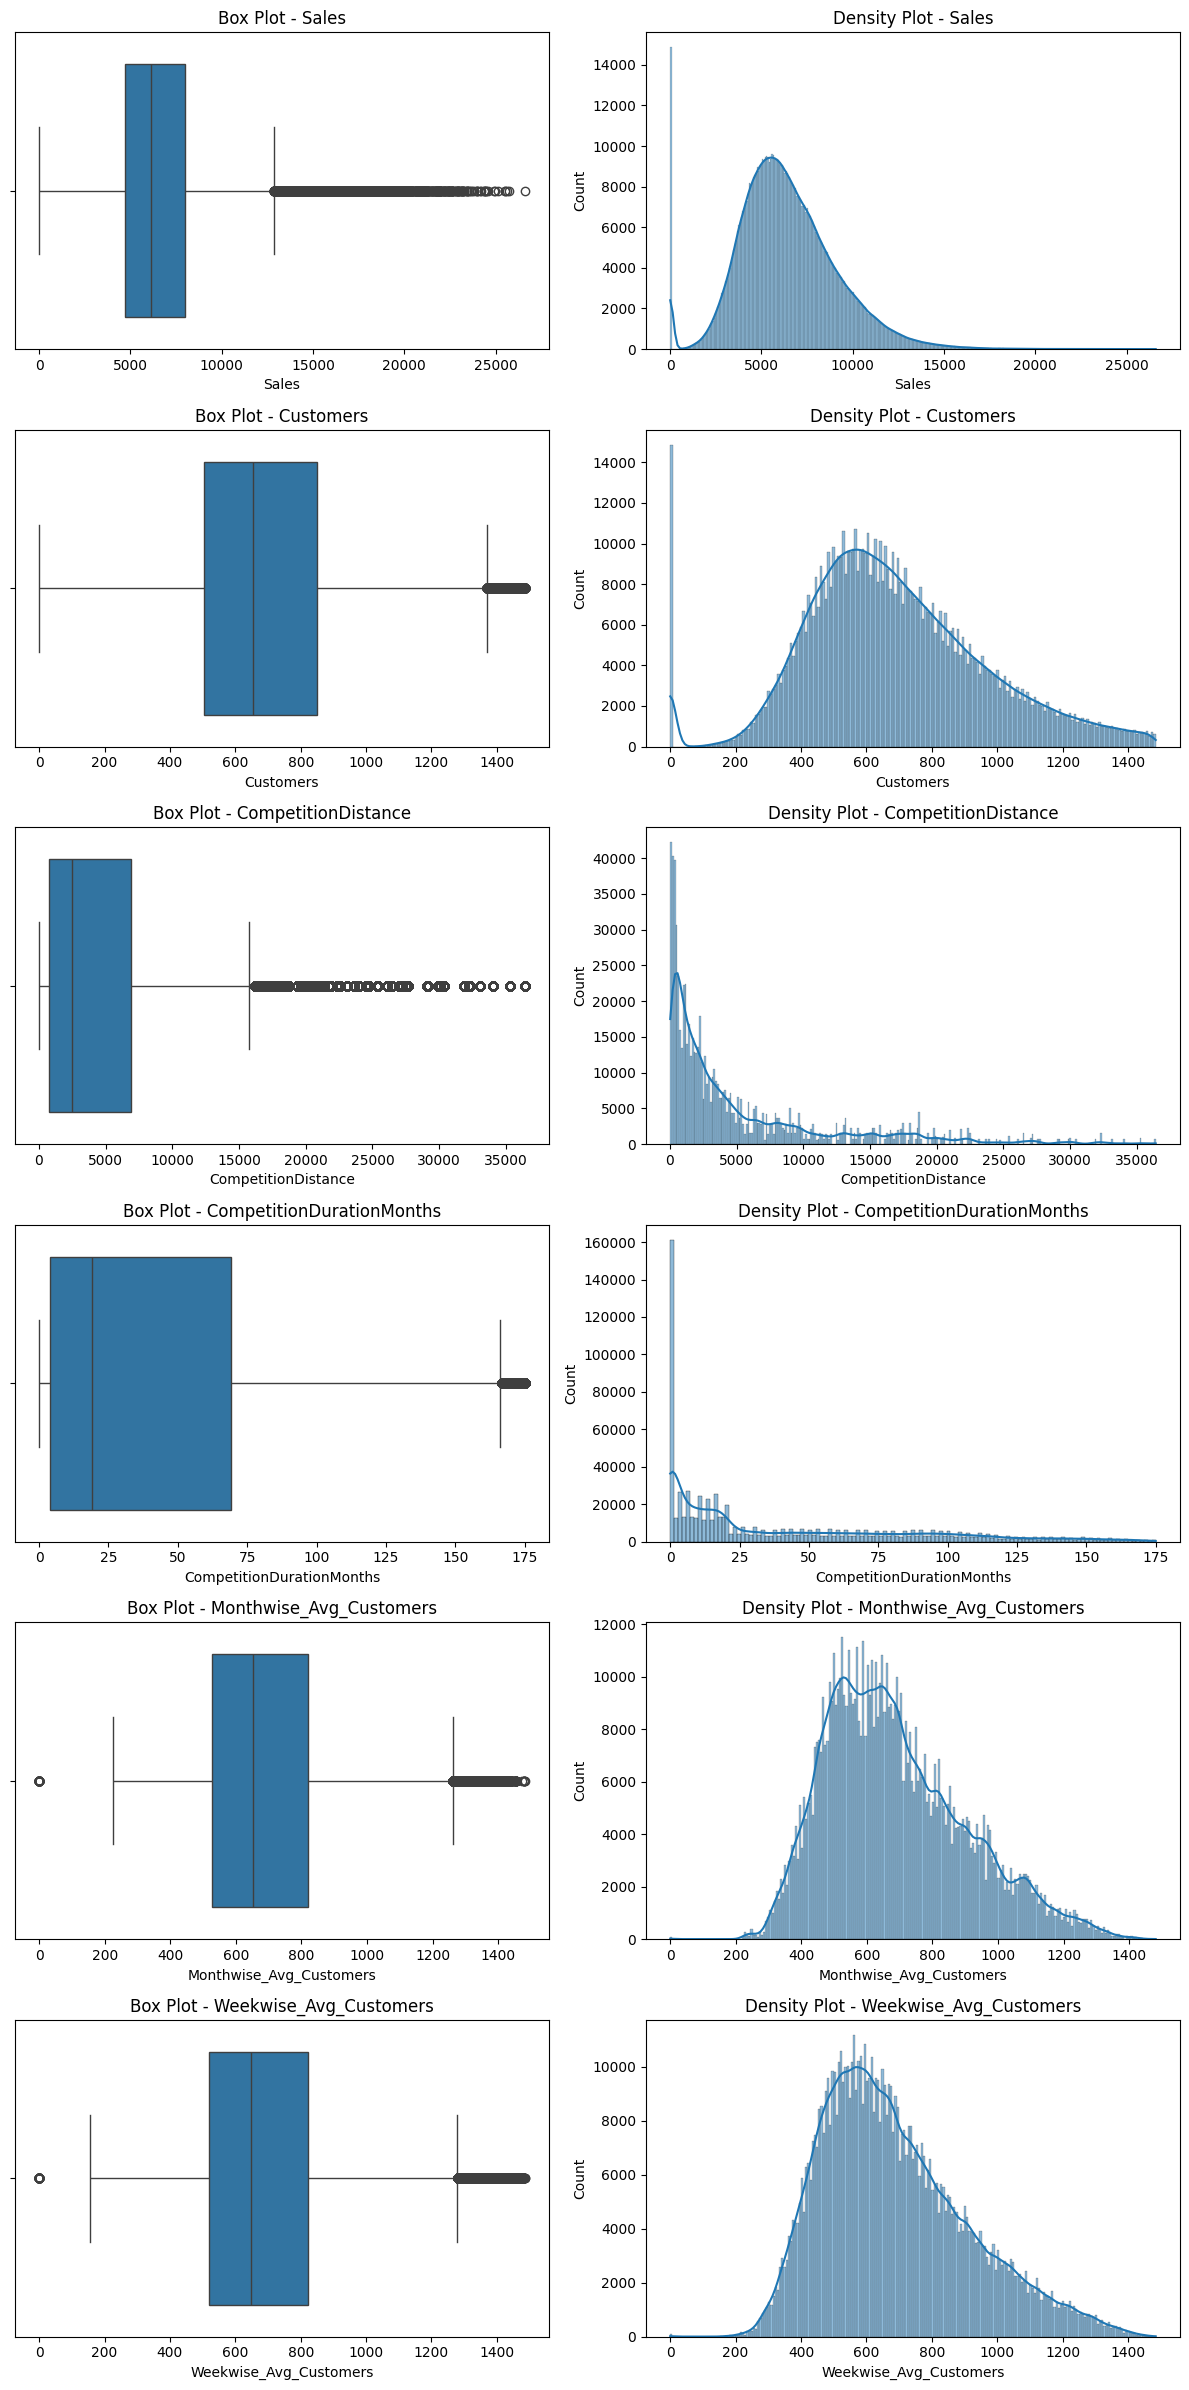

In [ ]:
continuous_variables=  ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionDurationMonths',
       'Monthwise_Avg_Customers', 'Weekwise_Avg_Customers']
show_box_density_plot(new_df,continuous_variables)

* We can clearly see that features like 'Sales','CompetitionDistance' and 'CompetitionDurationMonths' are right skewed hence we will be performing root_transformation to these features.


In [ ]:
new_df[new_df['Sales']==0].shape,unseen_data[unseen_data['Sales']==0].shape

((14858, 26), (0, 26))

In [ ]:
new_df[new_df['Sales']==0]['Holiday'].value_counts()

Holiday
1    14806
0       52
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import FunctionTransformer

root_transformer = FunctionTransformer(np.sqrt, validate=True)
for feature in ['Sales', 'CompetitionDistance', 'CompetitionDurationMonths']:
  new_df[feature] = root_transformer.transform(new_df[feature].values.reshape(-1, 1))
  unseen_data[feature] = root_transformer.transform(unseen_data[feature].values.reshape(-1, 1))

**Feature Transformation in Categorical features**

* Performing Label Encoding on categorical features in both new_df and unseen_data.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
categorical_cols = ['DayOfWeek', 'StoreType', 'Assortment']
for feature in categorical_features:
   new_df[feature] = label_encoder.fit_transform(new_df[feature])

   unseen_data[feature] = label_encoder.fit_transform(unseen_data[feature])

Splitting the main data to **train** and **test** data

Let's first check the size of **new_df** and **unseen_data**.

In [ ]:
new_df.shape,unseen_data.shape

((756371, 26), (42373, 26))

* Creating a copy of **'new_df'** say **'X'** which hold all other features except **'Sales'**
* Creating a copy of **'Sales'** feature of **new_df** into a new dataframe say **'y'**

In [ ]:
X = new_df.drop(['Sales'],axis=1).copy()

y = pd.DataFrame(new_df['Sales'])

* Since we are dealing with a time series data so we can not split the given data into train, validation and test on random basis. We will be splitting the data based on different time spans
* Splitting **'X'** and **'y'** into **80:20** ratio.
* **'X_loc_test_data'** and **'y_loc_test_data'** contains **20%** percent of **'X'** and **'y'**.
* **'X_train'** and **'y_train'** contains remaining **80%** of **'X'** and **'y'**.




In [ ]:
X_loc_test_data =  math.floor(len(X) * 0.20)
X_loc_test = X.head(X_loc_test_data)

y_loc_test_data = math.floor(len(y) * 0.20)
y_loc_test = y.head(y_loc_test_data)

X_train = X.iloc[X_loc_test_data:]
y_train = y.iloc[y_loc_test_data:]


In [ ]:
print("the number of rows and columns of X_train :",X_train.shape )
print("the number of rows and columns of y_train :",y_train.shape )
print("the number of rows and columns of X_loc_test :",X_loc_test.shape )
print("the number of rows and columns of y_loc_test :",y_loc_test.shape )

the number of rows and columns of X_train : (605097, 25)
the number of rows and columns of y_train : (605097, 1)
the number of rows and columns of X_loc_test : (151274, 25)
the number of rows and columns of y_loc_test : (151274, 1)


Splitting the "X_loc_test" and "y_loc_test" dataset into "Test" and "Validation" dataframe with 50:50 ratio.

In [ ]:
X_test_data =  math.floor(len(X_loc_test) * 0.50)
X_test = X_loc_test.head(X_test_data)

y_test_data = math.floor(len(y_loc_test) * 0.50)
y_test = y_loc_test.head(y_test_data)

X_val = X_loc_test.iloc[X_test_data:]
y_val = y_loc_test.iloc[y_test_data:]

In [ ]:
date_range = []
for i in (X_train.Date, X_val.Date, X_test.Date):
    date_range.append([i.min(), i.max()])

print('Date range for X_train: ', date_range[0])
print("the number of rows and columns of X_train :",X_train.shape )

print('Date range for X_val: ', date_range[1])
print("the number of rows and columns of X_val :",X_val.shape )

print('Date range for X_test: ', date_range[2])
print("the number of rows and columns of X_test :",X_test.shape )

Date range for X_train:  [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-12-19 00:00:00')]
the number of rows and columns of X_train : (605097, 25)
Date range for X_val:  [Timestamp('2014-12-19 00:00:00'), Timestamp('2015-03-17 00:00:00')]
the number of rows and columns of X_val : (75637, 25)
Date range for X_test:  [Timestamp('2015-03-17 00:00:00'), Timestamp('2015-06-14 00:00:00')]
the number of rows and columns of X_test : (75637, 25)


In [ ]:
unseen_data.drop(columns = ['Date'],axis =1,inplace= True)

X_train.drop(columns = ['Date'],axis =1,inplace= True)
X_val.drop(columns = ['Date'],axis =1,inplace= True)
X_test.drop(columns = ['Date'],axis =1,inplace= True)

Let's check if the X_train, X_val, X_test are overlapping or not because overlapping or data leakage may effect the model performance.


In [ ]:
X_test.head(1)

DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday  StoreType  \
0          7        380     1      0             0              0          0   

   Assortment  CompetitionDistance  Promo2  ...  PromoMonth  PromoWeek  \
0           2           108.074049       1  ...           0          0   

   Promotions  Promo2Month  Difference_in_Promotions  Holiday  \
0           1            7                         0        0   

   Promo1_Participation_Week  Promo2_Participation_SinceWeek  \
0                          0                             846   

   Monthwise_Avg_Customers  Weekwise_Avg_Customers  
0                      568                     539  

[1 rows x 24 columns]

In [ ]:
X_test.tail(1)

DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
75636          2        458     1      1             0              0   

       StoreType  Assortment  CompetitionDistance  Promo2  ...  PromoMonth  \
75636          3           2           114.367828       1  ...           3   

       PromoWeek  Promotions  Promo2Month  Difference_in_Promotions  Holiday  \
75636         12           2            4                         1        0   

       Promo1_Participation_Week  Promo2_Participation_SinceWeek  \
75636                        331                             747   

       Monthwise_Avg_Customers  Weekwise_Avg_Customers  
75636                      474                     490  

[1 rows x 24 columns]

In [ ]:
X_val.head(1)

DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
75637          2       1016     1      1             0              0   

       StoreType  Assortment  CompetitionDistance  Promo2  ...  PromoMonth  \
75637          2           2            28.635642       0  ...           3   

       PromoWeek  Promotions  Promo2Month  Difference_in_Promotions  Holiday  \
75637         12           1            0                         0        0   

       Promo1_Participation_Week  Promo2_Participation_SinceWeek  \
75637                        335                               0   

       Monthwise_Avg_Customers  Weekwise_Avg_Customers  
75637                      970                     965  

[1 rows x 24 columns]

In [ ]:
X_val.tail(1)

DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
151273          5        749     1      1             0              0   

        StoreType  Assortment  CompetitionDistance  Promo2  ...  PromoMonth  \
151273          3           0           100.895986       0  ...          12   

        PromoWeek  Promotions  Promo2Month  Difference_in_Promotions  Holiday  \
151273         51           1            0                         0        0   

        Promo1_Participation_Week  Promo2_Participation_SinceWeek  \
151273                        334                               0   

        Monthwise_Avg_Customers  Weekwise_Avg_Customers  
151273                      596                     804  

[1 rows x 24 columns]

In [ ]:
X_train.head(1)

DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
151274          5        763     1      1             0              0   

        StoreType  Assortment  CompetitionDistance  Promo2  ...  PromoMonth  \
151274          0           0            21.213203       0  ...          12   

        PromoWeek  Promotions  Promo2Month  Difference_in_Promotions  Holiday  \
151274         51           1            0                         0        0   

        Promo1_Participation_Week  Promo2_Participation_SinceWeek  \
151274                        333                               0   

        Monthwise_Avg_Customers  Weekwise_Avg_Customers  
151274                      676                     842  

[1 rows x 24 columns]

In [ ]:
X_train.tail(1)

DayOfWeek  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
756370          2          0     0      0             1              1   

        StoreType  Assortment  CompetitionDistance  Promo2  ...  PromoMonth  \
756370          3           2            73.143694       1  ...           0   

        PromoWeek  Promotions  Promo2Month  Difference_in_Promotions  Holiday  \
756370          0           1            6                         0        1   

        Promo1_Participation_Week  Promo2_Participation_SinceWeek  \
756370                          0                             752   

        Monthwise_Avg_Customers  Weekwise_Avg_Customers  
756370                      374                     333  

[1 rows x 24 columns]

### Feature Selection

In [ ]:
def handling_correlation(X_train,threshold):
    corr_features = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j])>threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

In [ ]:
drop_features = handling_correlation(X_train,0.8)
drop_features

['Holiday',
 'Weekwise_Avg_Customers',
 'Promo2SinceYear',
 'Promo2_Participation_SinceWeek',
 'Promo2Month',
 'PromoWeek',
 'Promo1_Participation_Week',
 'StateHoliday',
 'PromoMonth']

In [ ]:
drop_features = ['WeekOfYear','Promo2Month','PromoWeek','Promotions','PromoMonth','Promo','Difference_in_Promotions','SchoolHoliday',
                     'Promo2','StateHoliday','Holiday','Open']

X_train.drop(columns = drop_features,axis=1,inplace = True)
X_val.drop(columns = drop_features,axis=1,inplace = True)
X_test.drop(columns = drop_features,axis=1,inplace = True)
unseen_data.drop(columns = drop_features,axis=1,inplace = True)

In [ ]:
features = X_train.columns

train_features=X_train[features]
val_features=X_val[features]
test_features=X_test[features]
unseen_df = unseen_data.copy()
actual = pd.DataFrame(unseen_df['Sales'])
unseen_df_features=unseen_df[features]

##**Modelling**

In [ ]:
def Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction):
  metrics = {}

  metrics['train_rmse'] = mean_squared_error(y_train, train_prediction, squared=False)
  metrics['train_r2'] = r2_score(y_train, train_prediction)

  metrics['val_rmse'] = mean_squared_error(y_val, val_prediction, squared=False)
  metrics['val_r2'] = r2_score(y_val, val_prediction)


  metrics['test_rmse'] = mean_squared_error(y_test, test_prediction, squared=False)
  metrics['test_r2'] = r2_score(y_test, test_prediction)

  return metrics

def results(metrics):
  print(f"Training Data\nR2    : {metrics['train_r2']}\nRMSE  : {metrics['train_rmse']}")
  print(f"\nValidation Data\nR2    : {metrics['val_r2']}\nRMSE  : {metrics['val_rmse']}")
  print(f"\nTesting Data\nR2    : {metrics['test_r2']}\nRMSE  : {metrics['test_rmse']}")


In [ ]:
MSE_Score = []
R2_Score = []
Algorithm = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

At first we wiil be making some base models using all the features.

In [ ]:
Algorithm.append('DecisionTreeRegressor')
regressor = DecisionTreeRegressor()
regressor.fit(train_features, y_train)

train_prediction = regressor.predict(train_features)
val_prediction = regressor.predict(val_features)
test_prediction =  regressor.predict(test_features)

In [ ]:
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])

Training Data
R2    : 0.9999984566163854
RMSE  : 0.02258551793592762

Validation Data
R2    : 0.9562561208893079
RMSE  : 4.426055997784144

Testing Data
R2    : 0.9485561516937359
RMSE  : 4.626866997131252


In [ ]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['DecisionTreeRegressor'],[4.626866997131252],[0.9485561516937359],

In [ ]:
import xgboost as xgb
Algorithm.append('XGB Regressor')
regressor = xgb.XGBRegressor()
regressor.fit(train_features, y_train)

train_prediction = regressor.predict(train_features)
val_prediction = regressor.predict(val_features)
test_prediction =  regressor.predict(test_features)

In [ ]:
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])


Training Data
R2    : 0.9687807367169394
RMSE  : 3.212213750769701

Validation Data
R2    : 0.9715915061245612
RMSE  : 3.5668296048359975

Testing Data
R2    : 0.9628412126488127
RMSE  : 3.932339967775825


In [ ]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['DecisionTreeRegressor', 'XGB Regressor'],[4.626866997131252, 3.932339967775825],[0.9485561516937359, 0.9628412126488127],

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

Algorithm.append('LGBM Regressor')

regressor = LGBMRegressor(force_row_wise=True)
regressor.fit(train_features, y_train)


train_prediction = regressor.predict(train_features)
val_prediction = regressor.predict(val_features)
test_prediction =  regressor.predict(test_features)
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])

[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 605097, number of used features: 12
[LightGBM] [Info] Start training from score 78.080275
Training Data
R2    : 0.9459388902380037
RMSE  : 4.2270325299737666

Validation Data
R2    : 0.9593013892888695
RMSE  : 4.269215230454878

Testing Data
R2    : 0.9476558201020249
RMSE  : 4.66717935838638


In [ ]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('RandomForestRegressor')
regressor = RandomForestRegressor()
regressor.fit(train_features, y_train)

train_prediction = regressor.predict(train_features)
val_prediction = regressor.predict(val_features)
test_prediction =  regressor.predict(test_features)

In [ ]:
metrics = Model_Metrics(y_train,train_prediction,y_val,val_prediction,y_test,test_prediction)
results(metrics)
MSE_Score.append(metrics['test_rmse'])
R2_Score.append(metrics['test_r2'])

Training Data
R2    : 0.9972386937288528
RMSE  : 0.9553233685841572

Validation Data
R2    : 0.9804400622505459
RMSE  : 2.959661151972012

Testing Data
R2    : 0.9752060266488426
RMSE  : 3.212131794086931


In [ ]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['DecisionTreeRegressor', 'XGB Regressor', 'LGBM Regressor', 'RandomForestRegressor'],[4.626866997131252, 3.932339967775825, 4.66717935838638, 3.212131794086931],[0.9485561516937359, 0.9628412126488127, 0.9476558201020249, 0.9752060266488426],

In [ ]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])
Comparison

Algorithm  MSE_Score  R2_Score
0  DecisionTreeRegressor   4.626867  0.948556
1          XGB Regressor   3.932340  0.962841
2         LGBM Regressor   4.667179  0.947656
3  RandomForestRegressor   3.212132  0.975206

**Feature Importance based on Model**

<Axes: xlabel='Importance', ylabel='Variable'>

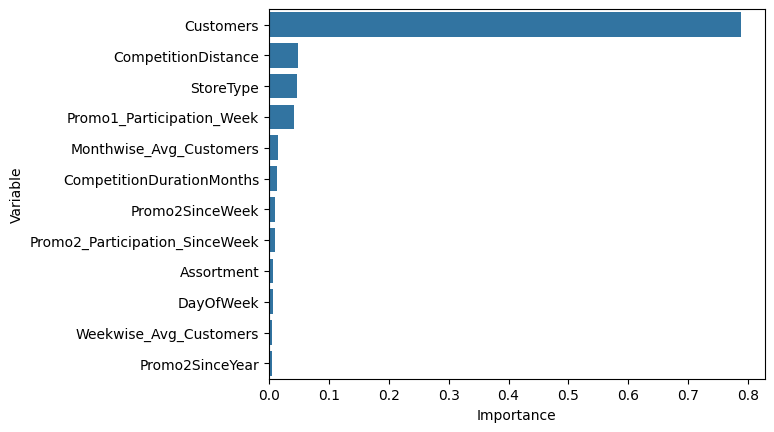

In [ ]:
feature_imp = pd.DataFrame({"Variable":train_features.columns,"Importance": regressor.feature_importances_})
feature_imp.sort_values(by="Importance", ascending=False, inplace = True)
sns.barplot(x=feature_imp['Importance'], y= feature_imp['Variable'])

* We can see that the base model using **RandomForestRegressor** is giving highest R^2 value with with lowest RMS value among all three algorithms we are using.

* Hence we will be doing hyperparameter tunning on the model made out of **'RandomForestRegressor'**.

##**Hyper-Parameter Tuning**

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(train_features, y_train)

prediction =  regressor.predict(unseen_df_features)
print('Model Performance in unseen_data:')
print('MSE:',mean_squared_error(actual, prediction, squared=False))
print('R2:',r2_score(actual, prediction))

Model Performance in unseen_data:
MSE: 3.57716495422271
R2: 0.9454274283604606


Since Random Forest regressor is a tree based algorithm so it takes a lot of time to execute. Due to lack of ram colab is crashing hence we will be performing hyper parameter tuning in the next part of our project.


**Creating and saving train, test and validation datasets for further work in new colab**

In [ ]:
# Concatinating features and their corresponding target variable and creating new data frames namely train, validation, test, unseen
train = pd.concat([train_features, y_train], axis=1)
validation = pd.concat([val_features, y_val], axis=1)
test = pd.concat([test_features, y_test], axis=1)
unseen = pd.concat([unseen_df_features, actual], axis=1)

train.reset_index(drop=True,inplace=True)
validation.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
unseen.reset_index(drop=True,inplace=True)

Rossman_train = train.to_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/Rossman_train",index=False)
Rossman_validation = validation.to_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/Rossman_validation",index=False)
Rossman_test = test.to_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/Rossman_test",index=False)
Rossman_unseen = unseen.to_csv("/content/drive/MyDrive/Colab Notebooks/ML Projects/ML- datasets/Rossman_unseen",index=False)


https://colab.research.google.com/drive/19Ft2RKlt9Up-52rFdmyWucjx0bjvMMxm?usp=sharing